##### Author: Tobias Flörchinger, 608227, floercht@hu-berlin.de

# Advanced Data Analytics for Management Support - <br> Assignment Submission

## Table of Contents
1. [Introduction](#first-bullet)
2. [Exploratory Data Analysis & Pre-Processing of non-Text Data](#second-bullet)
<br> 2.1 Host Features
<br> 2.2 Location Features
<br> 2.3 Airbnb Typ, Furnishing & Equipment
<br> 2.4 Reviews & Cancellation
<br> 2.5 Airbnb Prices
3. [Text Data Pre-Processing](#third-bullet)
<br> 3.1 Subset Detection
<br> 3.2 Text Data Cleaning & Correction
4. [Feature Engineering & Selection](#fourth-bullet)
<br> 4.1 Meta Data, Transformations & Dummy Encoding
<br> 4.2 Non-Text Feature Selection
5. [Natural Language Processing & Transfer Learning](#fifth-bullet)
<br> 5.1 Latent Semantic Analysis
<br> 5.2 Fine-Tuned Sentence-BERT
<br> 5.3 Recurrent Neural Networks 
6. [Feedforward Neural Network for Price Prediction](#sixth-bullet)
7. [Conclusion](#seventh-bullet)
8. [Literature](#eight-bullet)

## 1. Introduction <a class='anchor' id='first-bullet'></a>

The pricing of a Airbnb unit is an important consideration for hosts that are about to list their properties on the platform. The high competition - especially in huge cities like London - makes the span, between being overpriced and less considered by customers or underpriced and booked up with potential revenue losses, quite small. Hence finding an optimum occupancy that maximizes revenues in the inverse relationship between price and occupancy is desirable. This represent a potential real world used-case of this notebook, even though it will not be of central interest for the sake of the assignment.

According to the description of the underlying kaggle challenge the aim of this assignment is to predict the price of Airbnb listings in the London area. Those are given as costs a customer faces when booking a one night stay. The structure of the two provided raw datasets - `train` and `test` - indicates a supervised learning problem with `train` having labeled prices. Further they both include tabular and text data that are to be combined for `price` prediction using NLP techniques. For the predictions a Neural Network based model needs to build. The additional resources listing reviews and property images will not be used in this notebook.

Let's first check whether all required modules are installed. Note that missing modules have to be installed manually i.e. using `pip`.

In [1]:
packages_installed = !pip list # Get a list of installed packages
packages_installed = [x.split()[0] for x in packages_installed] # Get names and convertion to list

# Needed packages
needed_packages = ['pandas', 'numpy', 'matplotlib', 'matplotlib-venn', 'scikit-learn', 'regex', 
                   'beautifulsoup4', 'nltk', 'gensim', 'langdetect', 'inflect', 'pyenchant',
                   'torch', 'tensorflow', 'transformers', 'sentence-transformers'] 

# Iterate over needed packages and check whether they are installed
for pack in needed_packages:
    if pack in packages_installed:
        print('Module is already installed: %s' %pack)
    else:
        print('NOTE: Module %s needs to be installed!' %pack) 

Module is already installed: pandas
Module is already installed: numpy
Module is already installed: matplotlib
Module is already installed: matplotlib-venn
Module is already installed: scikit-learn
Module is already installed: regex
Module is already installed: beautifulsoup4
Module is already installed: nltk
Module is already installed: gensim
Module is already installed: langdetect
Module is already installed: inflect
Module is already installed: pyenchant
Module is already installed: torch
Module is already installed: tensorflow
Module is already installed: transformers
Module is already installed: sentence-transformers


With all modules being installed the required libraries and functions can be imported.

In [2]:
import os # Importing and writing data
import numpy as np # Numerical operations
import pandas as pd # General data managment & wrangling 
import re # Regular expressions functionality
import time # Track runtimes
import pickle # Saving and loaded objects
import random # Get random sequence
import multiprocessing # Core detection
from numpy.random import seed # Set random state

# For plots
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Mainly for the NLP pre-processing workflow
import datetime
import inflect
import enchant
from langdetect import detect
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from bs4 import BeautifulSoup
from collections import Counter
from gensim.models import KeyedVectors, Word2Vec
from gensim.models.keyedvectors import Word2VecKeyedVectors

# For Latent Semantic Analysis, general model & feature selection as well as feature scaling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler, RobustScaler

# For Sentence-BERT
import torch
import transformers
from torch.utils.data import DataLoader
from sentence_transformers import losses as losses_trans
from sentence_transformers import SentenceTransformer, models, InputExample, evaluation

# For Recurrent and Feedforward Neural Networks
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant, he_normal
from tensorflow.keras import initializers, optimizers, regularizers
from tensorflow.keras.layers import Input, concatenate, Dense, Embedding, GRU, LSTM, Bidirectional, Dropout
from tensorflow.keras import activations, losses, initializers, optimizers, regularizers

Note that the models of this Notebooke are trained on the CPU. In the most cases this ensures reproducibility but it is also computationally expensive. Hence [data and interim results are provided via a cloud service](https://www.dropbox.com/sh/5of2lc58qmkk8bk/AADzQndCICjT1lAQo6Mp3RHFa?dl=0) and can be loaded to bypass time consuming sections. For writing and reading data the directory of the notebook is used and hence it is saved as `path`. At first the assignment datasets `train.csv` and `test.csv` are loaded from there and labeled as `df_known` and `df_unknown`.

In [3]:
# Define dirctory of the notebook as path
path = os.path.dirname(os.path.realpath('608227.ipynb'))

# Load assignment datasets 
df_known = pd.read_csv(os.path.join(path, 'train.csv'))
df_unknown = pd.read_csv(os.path.join(path, 'test.csv'))

# Merge datasets for text data pre-processing
df_merged = pd.concat([df_known,df_unknown]).reset_index(drop=True)

With the following chapters the notebook entails a initial exploratory data analysis with data preperation of non-text data, a stand alone section for preperation of text data, feature engineering & selection of non-text data, feature extraction from text data with NLP techniques as well as their selection and finally the creation of a Neural Network model for the prediction of Airbnb prices.

## 2. Exploratory Data Analysis & Pre-Processing of non-Text Data  <a class='anchor' id='second-bullet'></a>
At first the raw datasets are investigated in an explanatory way to gain insights about data peculiarities and structures. Summary statistics and graphical representations come in handy here. The aim is to improve the understanding for the features and to collect ideas for the subsequent sections. Whenever necessary non-text data is pre-processed. Note that a related [public notebook](https://github.com/L-Lewis/Airbnb-neural-network-price-prediction/blob/master/Airbnb-price-prediction.ipynb) served as source of inspiration for this section. Let's begin with some overviews.

In [4]:
# Show first three rows of df_known
df_known.head(5)

,name,summary,space,description,experiences_offered,neighborhood_overview,transit,house_rules,picture_url,host_id,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month,listing_id
0,Attic Room in historic Greenwich,The room does not have a door but its own disc...,Double room available in historic royal Greenw...,The room does not have a door but its own disc...,business,NaN,Parking is restricted in London. Visitors park...,no shoes on carpets no food in attic room no o...,https://a0.muscache.com/im/pictures/20045164/7...,2167992,...,95.0,10.0,10.0,10.0,10.0,10.0,10.0,strict_14_with_grace_period,2.37,9Q1RD6H7IO
1,Lovely Garden Studio Private Access,"Garden studio with private entrance, 5 minutes...","Beautiful studio with a king size bed, a sofa ...","Garden studio with private entrance, 5 minutes...",none,Crouch End is a very hip and friendly neighbou...,Walk across the street to the W3 bus stop and ...,We'd love it if you would remove your shoes at...,https://a0.muscache.com/im/pictures/8d1ddcdc-f...,16148175,...,99.0,10.0,10.0,10.0,10.0,10.0,10.0,moderate,2.97,6XDPZPGLSR
2,Comfi apartment 2 close to wimbledon tennis court,NaN,NaN,NaN,none,NaN,NaN,1- No party or event allowed. 2-No smoking ins...,https://a0.muscache.com/im/pictures/e7e4a740-d...,272000199,...,84.0,9.0,9.0,10.0,10.0,9.0,8.0,strict_14_with_grace_period,1.73,SND9OPN6IY
3,Luxury room in the heart of London - SW4,Luxury first floor Victorian split level maiso...,"Your room will be fully furnished, and it will...",Luxury first floor Victorian split level maiso...,none,"Gail coffee shop, just round the corner as wel...",Happy to advise on things to do in London and ...,- Check-in after 18:30pm and no later than 20:...,https://a0.muscache.com/im/pictures/7c2b2fcc-e...,3361233,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,flexible,NaN,SE3B7BXN9G
4,Excellent city Apartment with Private Patio,"NEW luxury apartment, with private outside pat...","A modern, well-equipped, cosy apartment close ...","NEW luxury apartment, with private outside pat...",none,NaN,NaN,"I am very happy for your visit, but please car...",https://a0.muscache.com/im/pictures/ca1494da-f...,94317022,...,100.0,10.0,10.0,10.0,10.0,10.0,10.0,strict_14_with_grace_period,2.32,E0C82VK0VF


Looking at the output shows that there are 42 columns in `df_known`. In the text feature columns are several `NaN` values visible and it is noticeable that `summary` and `description` share the same initial words in all entries.

In [5]:
# Get infos for df_known
df_known.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55284 entries, 0 to 55283
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   name                         55270 non-null  object 
 1   summary                      52330 non-null  object 
 2   space                        38403 non-null  object 
 3   description                  53558 non-null  object 
 4   experiences_offered          55284 non-null  object 
 5   neighborhood_overview        35778 non-null  object 
 6   transit                      35477 non-null  object 
 7   house_rules                  31906 non-null  object 
 8   picture_url                  55284 non-null  object 
 9   host_id                      55284 non-null  int64  
 10  host_since                   55173 non-null  object 
 11  host_response_time           37482 non-null  object 
 12  host_response_rate           37482 non-null  object 
 13  host_is_superhos

In [6]:
print('Except the target price, df_known and df_unknown consist of the same features: {}.'
      .format(set(df_known.drop(['price'], axis=1).copy()) == set(df_unknown)))
print(f'In df_unknown are {len(df_unknown)} entries.')

Except the target price, df_known and df_unknown consist of the same features: True.
In df_unknown are 29769 entries.


Most of the features are of the type `object`. Those include seven text features and otherwise indicate - apart from `picture_url` & `listing_id` - categorical features of nominal scale with possible dummy feature like `host_is_superhost`. Apart from `host_id`, the features of type `float` and `int` seem to be either of cardinal or of ordinal scale.

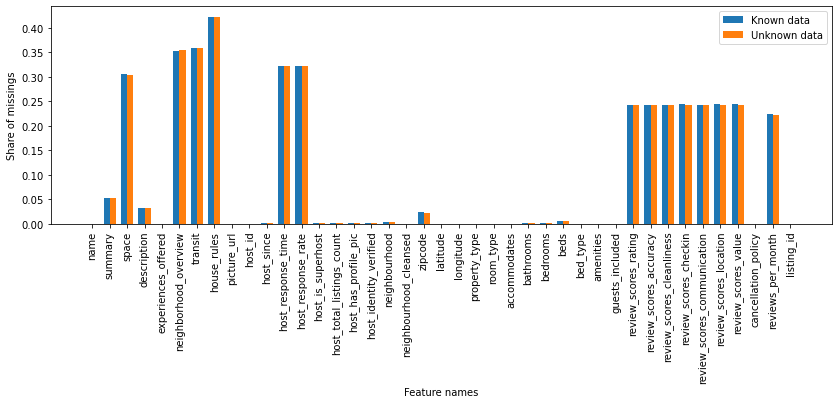

In [7]:
# Share of missings in df_known and df_unknown
known = round((df_known.drop(['price'], axis=1).copy().isnull().sum() / len(df_known.drop(['price'], axis=1).copy())), 3)
unknown = round((df_unknown.isnull().sum() / len(df_unknown)), 3)

# Plot
ind = np.arange(len(unknown))
width = 0.35
fig, ax = plt.subplots(figsize=(14,4))
rects1 = ax.bar(ind - width/2, known, width,
                label='Known data')
rects3 = ax.bar(ind + width/2, unknown, width,
                label='Unknown data')
ax.set_ylabel('Share of missings')
ax.set_xlabel('Feature names')
ax.set_xticks(ind)
ax.set_xticklabels(df_unknown.columns, rotation=90)
ax.legend();
plt.show()

Four text features, the features related to the host response and the review features show a large amount of missing values.

In [8]:
# Drop 'picture_url' since it will not be used in this notebook
df_known = df_known.drop(['picture_url'], axis=1).copy()
df_unknown = df_unknown.drop(['picture_url'], axis=1).copy()

### 2.1 Host Features

Let's get down to the feature level and take a look into the structure of each, starting with those that are related to the host.

In [9]:
print(df_known.experiences_offered.value_counts(normalize=True))
# Drop experiences_offered
df_known = df_known.drop(['experiences_offered'], axis=1).copy()
df_unknown = df_unknown.drop(['experiences_offered'], axis=1).copy()

none        0.980790
business    0.006584
family      0.005427
social      0.004812
romantic    0.002388
Name: experiences_offered, dtype: float64


Only roughly 2% of the entries in `experiences_offered` are not `none`. Hence this feature is dropped since it unlikely carries predictive information.

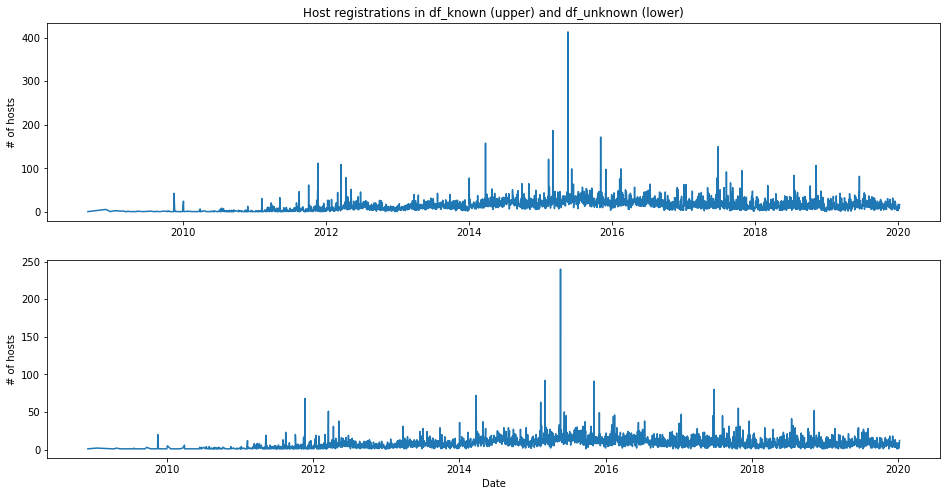

In [10]:
def plot_host_since(df):
    ''' The function converts date times and 
        extracts their frequencies in the datasets. '''
    date_list = []
    for i in range(len(df)):
        try:
            date_list.append(datetime.datetime.strptime(str(df.host_since[i]), '%Y-%m-%d'))
        except ValueError:
            continue
    date_list.sort()
    x = list(Counter(date_list).keys())
    y = list(Counter(date_list).values())
    return (x,y)

# Plot host_since
x0,y0 = plot_host_since(df_known)
x1,y1 = plot_host_since(df_unknown)
fig, axs = plt.subplots(2,figsize=(16,8))
axs[0].plot(x0,y0)
axs[0].set_ylabel('# of hosts')
axs[0].title.set_text('Host registrations in df_known (upper) and df_unknown (lower)')
axs[1].plot(x1,y1)
axs[1].set_ylabel('# of hosts')
axs[1].set_xlabel('Date')
plt.show()

Plotting `host_since` for both datasets shows that there are several peaks of registrations. Further it reveals that this feature has the same distribution in `df_known` and `df_unknown`. This indicates that both datasets are randomly samples from the population. 

In [11]:
# Calculating the number of days since registration
df_known['host_registered'] = (pd.to_datetime('2021-01-01') - pd.to_datetime(df_known.host_since) ).astype('timedelta64[D]')
df_unknown['host_registered'] = (pd.to_datetime('2021-01-01') - pd.to_datetime(df_unknown.host_since) ).astype('timedelta64[D]')

# Imputing missing values with the median
df_known.host_registered.fillna(df_known.host_registered.median(), inplace=True)
df_unknown.host_registered.fillna(df_known.host_registered.median(), inplace=True)

# Drop host_since
df_known = df_known.drop(['host_since'], axis=1).copy()
df_unknown = df_unknown.drop(['host_since'], axis=1).copy()

The difference of `host_since` to some arbitrary recent time point is calculated as time since the host registered (`host_registered`). Missing values in this new column get imputed with the median.

In [12]:
# Imputing null values with 'unknown'
df_known.host_response_time.fillna('unknown', inplace=True)
df_unknown.host_response_time.fillna('unknown', inplace=True)

# Get normalized frequencies
df_known.host_response_time.value_counts(normalize=True)

within an hour        0.433796
unknown               0.322010
within a few hours    0.128518
within a day          0.095398
a few days or more    0.020277
Name: host_response_time, dtype: float64

After imputing with `unknown` the most entries in `host_response_time` are `within an hour` and `unknown`.

In [13]:
# Convert percentage to float
df_known.host_response_rate = df_known.host_response_rate.str[:-1].astype('float64')
df_unknown.host_response_rate = df_unknown.host_response_rate.str[:-1].astype('float64')

In [14]:
def make_bins(df):
    ''' Bins host_response_rate into categories 
        and repraces nulls with 'unknown'. '''
    df.host_response_rate = pd.cut(df.host_response_rate, bins=[0, 55, 70, 80, 90, 95, 99, 100],
                                   labels=['0-54%', '55-69%', '70-79%', '80-89%', '90-94%', '95-99%', '100%'],
                                   include_lowest=True)
    df.host_response_rate = df.host_response_rate.astype('str')
    df.host_response_rate.fillna('unknown', inplace=True)
    
#Apply bins
make_bins(df_known)
make_bins(df_unknown)

# Get normalized frequencies of host_response_rate
df_known.host_response_rate.value_counts(normalize=True)

100%       0.467766
unknown    0.322010
80-89%     0.054320
95-99%     0.054139
0-54%      0.030009
90-94%     0.025251
70-79%     0.025089
55-69%     0.021417
Name: host_response_rate, dtype: float64

Nearly half of the `host_response_rate` entries are `100%` followed by the imputation value `unknown`.  

In [15]:
# Get normalized frequencies of host_is_superhost
print(df_known.host_is_superhost.value_counts(normalize=True))

# Convert all dummy feature entries to 0/1 values
df_known.replace({'f': 0, 't': 1}, inplace=True)
df_unknown.replace({'f': 0, 't': 1}, inplace=True)

f    0.85154
t    0.14846
Name: host_is_superhost, dtype: float64


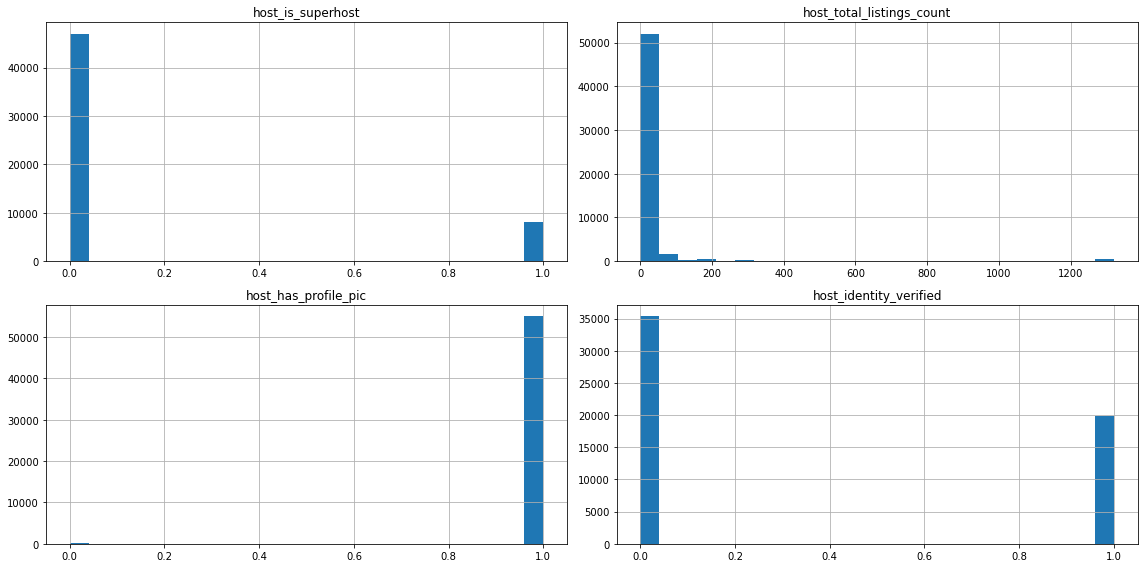

In [16]:
# Checking the distributions of remaining host features
to_plot = ['host_is_superhost','host_total_listings_count','host_has_profile_pic','host_identity_verified']
fig = plt.figure(figsize=(16,8))
for i, var_name in enumerate(to_plot):
    ax = fig.add_subplot(2,2,i+1)
    df_known[var_name].hist(bins=25,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [17]:
# Drop host_has_profile_pic
df_known = df_known.drop(['host_has_profile_pic'], axis=1).copy()
df_unknown = df_unknown.drop(['host_has_profile_pic'], axis=1).copy()

There are several dummy host features in  `df_known `. Here `host_has_profile_pic` is dropped since the entries belong mostly to one class. The `host_total_listings_count` and the remaining host dummy features get imputed with 0 by assuming that they do not show the respective feature.

In [18]:
# Imputing missing dummy values with 0
for col in ['host_is_superhost','host_identity_verified']:
    df_known[col].fillna(0, inplace=True)
    df_unknown[col].fillna(0, inplace=True)
    
# Imputing missing values of host_total_listings_count with median
df_known.host_total_listings_count.fillna(df_known.host_total_listings_count.median(), inplace=True)
df_unknown.host_total_listings_count.fillna(df_known.host_total_listings_count.median(), inplace=True)

### 2.2 Location Features

Now the features related with the location of a property that is listed on Airbnb are investigated.

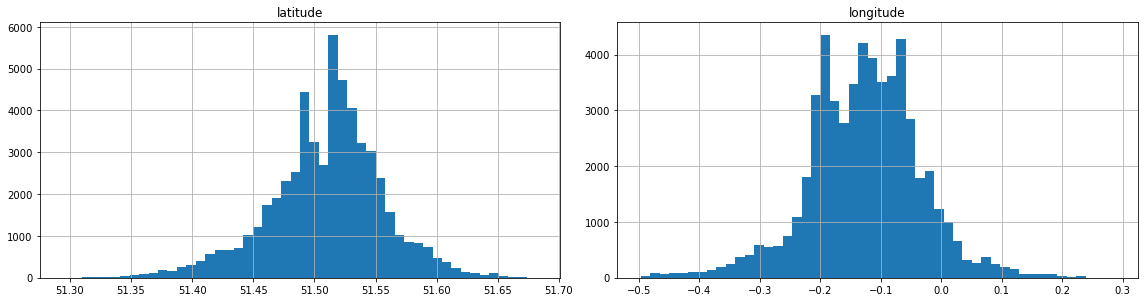

In [19]:
# Checking the distributions of latitude and longitude
to_plot = ['latitude','longitude']
fig = plt.figure(figsize=(16,8))
for i, var_name in enumerate(to_plot):
    ax = fig.add_subplot(2,2,i+1)
    df_known[var_name].hist(bins=50,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

As shown by the plots `latitude` and `longitude` most of the listings are located in the center of London and less in the area around London resulting the features to show a gaussian distribution shape. It is likely that those are non linearly related to `price` as prices for housing tend to be higher in the city center. East/west and north/south differences are also possible.

In [20]:
# Get normalized frequencies of neighbourhood_cleansed
df_known.neighbourhood_cleansed.value_counts(normalize=True)

Westminster               0.108729
Tower Hamlets             0.098292
Hackney                   0.074796
Camden                    0.071178
Kensington and Chelsea    0.066855
Islington                 0.059402
Lambeth                   0.058299
Southwark                 0.057811
Wandsworth                0.049942
Hammersmith and Fulham    0.048043
Brent                     0.029755
Lewisham                  0.026952
Haringey                  0.025631
Newham                    0.024347
Ealing                    0.021127
Greenwich                 0.020422
Barnet                    0.019952
Waltham Forest            0.018052
Merton                    0.015520
Richmond upon Thames      0.014145
Croydon                   0.013404
Hounslow                  0.013024
Redbridge                 0.008664
Enfield                   0.008538
Bromley                   0.008266
Hillingdon                0.007471
Kingston upon Thames      0.006548
City of London            0.005372
Harrow              

In [21]:
# Get normalized frequencies of neighbourhood
df_known.neighbourhood.value_counts(normalize=True)

City of Westminster    0.059706
LB of Tower Hamlets    0.052814
LB of Hackney          0.046194
LB of Islington        0.043655
LB of Camden           0.037398
                         ...   
Downham                0.000290
Honor Oak              0.000218
Dulwich Village        0.000163
Putney Heath           0.000109
Beckenham              0.000109
Name: neighbourhood, Length: 149, dtype: float64

In [22]:
# Get normalized frequencies of zipcode
df_known.zipcode.value_counts(normalize=True)

E1          0.005406
NW1         0.004832
N1          0.004240
SE1         0.003851
E2          0.003610
              ...   
SW4 6EH     0.000019
DA15 9NQ    0.000019
WC1E 7HG    0.000019
E8 3AQ      0.000019
N8 7LA      0.000019
Name: zipcode, Length: 26556, dtype: float64

The features `neighbourhood_cleansed`, `neighbourhood` and `zipcode` cluster the listings by areas in London and on different granularity levels. The lowest granularity level `neighbourhood_cleansed` resembles the london boroughs, followed by the districts  `neighbourhood` on the medium level. `zipcode` has the highest granularity and is related to the postcode districts. However `zipcode` has full addresses as entries and hence an inflated amount of unique entries (i.e. 26556) that require processing.

In [23]:
def get_zipcode(df):
    ''' Separates the adress components of entries from the zipcode
        and converts missing values to 'unknown'. '''
    df['zipcode'].apply(str)
    for i in range(0, df.shape[0]):
        zc = df.iloc[i, df.columns.get_loc('zipcode')]
        if type(zc) is str:
            zc = zc.split(' ') 
            df.iloc[i, df.columns.get_loc('zipcode')] = zc[0]
        else:
            df.iloc[i, df.columns.get_loc('zipcode')] = 'unknown'
            
# Apply get_zipcode
get_zipcode(df_known)
get_zipcode(df_unknown)

In [24]:
def clean_zipcode(df):
    ''' Transforms all zipcode entries to capital letters and removes possibly mistyped numbers 
        (Only those that are in the same place in QWERTZ and QWERTY layout). '''
    trans_zc = []
    for i in range(0, df.shape[0]):
        trans_zc.append(re.sub(r'!','1',df.zipcode[i].upper()))
        trans_zc[i] = re.sub(r'$','4',trans_zc[i])
        trans_zc[i] = re.sub(r'%','5',trans_zc[i][:-1])
    return(trans_zc)

# Apply clean_zipcode
df_known.zipcode = clean_zipcode(df_known)
df_unknown.zipcode = clean_zipcode(df_unknown)

print(f'After an initial processing zipcode consists of {len(df_known.zipcode.unique())} unique entries in df_known.')

After an initial processing zipcode consists of 959 unique entries in df_known.


Since some artifacts might not be detected by the function `get_zipcode`, i.e. address and postcode written together without space, a entry is required to occurance at least twice in `df_known` otherwise the `zipcode` entry is set to `NaN`.

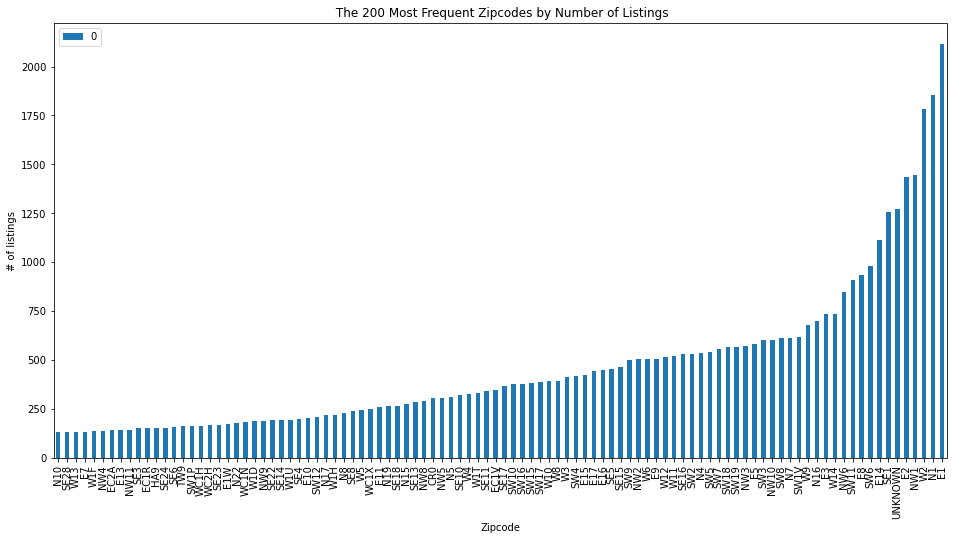

In [25]:
def zipcode_min(df, minimum):
    ''' Counts the occurance of unique zipcodes and 
        sets zipcodes to missing if a minimim count is not reached. '''
    nb_counts = Counter(df_known.zipcode)
    for i in list(nb_counts):
        if nb_counts[i] <= minimum:
            del nb_counts[i]
            df.loc[df.zipcode == i, 'zipcode'] = np.nan
    return(nb_counts)

# Apply zipcode_min with minimum = 2
nb_counts = zipcode_min(df_known, 2)
zipcode_min(df_unknown, 2)

# Plot zipcodes for df_known     
tdf = pd.DataFrame.from_dict(nb_counts, orient='index').sort_values(by=0)
ax = tdf.iloc[200: , :].plot(kind='bar', figsize = (16,8))
ax.set_title(' The 200 Most Frequent Zipcodes by Number of Listings')
ax.set_xlabel('Zipcode')
ax.set_ylabel('# of listings')
plt.show()

The plot shows that the majority of the most frequent postcodes is proper. Here the large amount of `UNKNOWN` entries is noticeable.

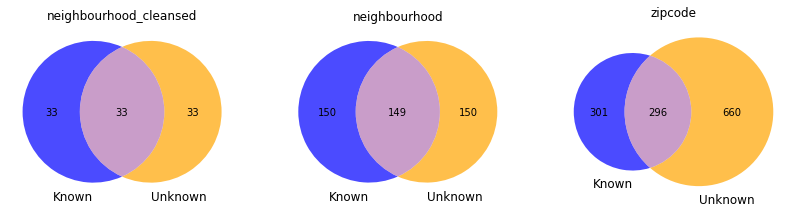

In [26]:
L_venn = ['neighbourhood_cleansed', 'neighbourhood', 'zipcode']

# Generate subplots to be filled by ven diagramms
fig, axs = plt.subplots(ncols=3,figsize=(14, 6))

# Generate ven diagramms
for i in range(0, len(L_venn)):
    overlap = pd.merge(df_known[L_venn[i]].value_counts(), df_unknown[L_venn[i]].value_counts(), how='left', 
                       left_index=True, right_index=True).count(axis=0)[1] 
    v1 = venn2(subsets = (len(df_known[L_venn[i]].unique()), len(df_unknown[L_venn[i]].unique()), overlap), 
               set_labels = ('Known', 'Unknown'), set_colors=('blue', 'orange'), alpha = 0.7, ax=axs[i])
    # Fill subplots
    axs[i].set_title(L_venn[i])
plt.show()

The venn diagramms display that several entries in `zipcode` appear to be in `df_known` but not in `df_unknown` and vice versa. This holds also true for `neighbourhood`. Those entries are - together with `UNKNOWN` entries - set to `NaN`. These missing values are imputed from `df_known` via the available entry of the location feature with the next lower level of granularity and the most frequent higher granularity candidate belonging to that unique lower granularity entry.

In [27]:
def zip_to_nan(df, df_to_nan):
    ''' Set zipcodes that are 'UNKNOWN' to missing as well as 
        those that are not present in both datasets. '''
    df_to_nan.loc[df_to_nan.zipcode == 'UNKNOWN', 'zipcode'] == np.nan
    liste = [var for var in list(df_to_nan['zipcode'].value_counts().index) 
             if var not in list(df['zipcode'].value_counts().index)]
    for i in range(0,len(liste)):
        df_to_nan.loc[df_to_nan.zipcode == liste[i], 'zipcode'] = np.nan
        
# Apply zip_to_nan
zip_to_nan(df_known, df_unknown)
zip_to_nan(df_unknown, df_known)

In [28]:
def imp_location(df, to_imp, imp_col):
    ''' Imputation of location features based on df_known entries. The feature with higher granularity 
        gets imputed with the most frequent same granularity instance in the next lower granularity feature. '''
    liste = list(df[to_imp])
    for i in df[df[to_imp].isna()].index:
            liste[i] = df_known[to_imp][df_known[imp_col] == df[imp_col][i]].value_counts().index[0]
    df[to_imp] = liste

# Apply imp_location
imp_location(df_known, 'neighbourhood', 'neighbourhood_cleansed')
imp_location(df_unknown, 'neighbourhood', 'neighbourhood_cleansed')
imp_location(df_known, 'zipcode', 'neighbourhood')
imp_location(df_unknown, 'zipcode', 'neighbourhood')

### 2.3 Airbnb Typ, Furnishing & Equipment

Next the features that describe the kind of the Airbnb unit and its characteristic are scrutinized.

In [29]:
# Get frequencies of property_type
df_known.property_type.value_counts()

Apartment             36986
House                 11543
Townhouse              1917
Condominium            1717
Serviced apartment      931
Loft                    496
Bed and breakfast       372
Guest suite             239
Guesthouse              211
Other                   144
Boutique hotel          140
Hotel                    98
Hostel                   95
Bungalow                 92
Cottage                  61
Boat                     45
Aparthotel               35
Tiny house               35
Villa                    24
Houseboat                22
Earth house              14
Cabin                    13
Camper/RV                10
Hut                       9
Yurt                      5
Barn                      4
Chalet                    4
Dome house                4
Treehouse                 3
Farm stay                 3
Tent                      3
Island                    2
Bus                       2
Campsite                  1
Parking Space             1
Plane               

In [30]:
# Replacing categories that are types of houses or apartments
Replace = {# Apartment and Tiny house
           'Loft': 'Apartment',
           'Guesthouse': 'Tiny house',
           # Hotel
           'Bed and breakfast': 'Hotel',
           'Aparthotel': 'Hotel',
           'Hostel': 'Hotel',
           'Serviced apartment': 'Hotel',
           'Boutique hotel': 'Hotel',
           'Guest suite': 'Hotel',
           # House_fancy
           'Bungalow': 'Fancy',
           'Cottage': 'Fancy',
           'Villa': 'Fancy',
           'Earth house': 'Fancy',
           'Chalet': 'Fancy',
           'Houseboat': 'Fancy',
           'Boat': 'Fancy'}
df_known.property_type.replace(Replace, inplace=True)
df_unknown.property_type.replace(Replace, inplace=True)

# Replacing other categories with 'other'
df_known.loc[~df_known.property_type.isin(['House','Townhouse','Tiny house','Apartment','Condominium','Hotel','Fancy']),
             'property_type'] = 'Other'
df_unknown.loc[~df_unknown.property_type.isin(['House','Townhouse','Tiny house','Apartment','Condominium','Hotel','Fancy']),
               'property_type'] = 'Other'

Some `property_type` entries appear seldom in `df_known` and possible not at all in `df_unknown`. Here those that occure with a reasonable high frequence get contentwise clusted. Low frequent entries are labeled as `Other`.

In [31]:
# Get frequencies of room_type
df_known.room_type.value_counts(normalize=True)

Entire home/apt    0.551769
Private room       0.430812
Hotel room         0.009750
Shared room        0.007669
Name: room_type, dtype: float64

In [32]:
# Get frequencies of bed_type
print(df_known.bed_type.value_counts(normalize=True))

# Drop bed_type
df_known = df_known.drop(['bed_type'], axis=1).copy()
df_unknown = df_unknown.drop(['bed_type'], axis=1).copy()

Real Bed         0.992403
Pull-out Sofa    0.004323
Futon            0.002098
Couch            0.000687
Airbed           0.000488
Name: bed_type, dtype: float64


The majority of `room_type` consists of `Entire home/apt` and `Private room`. The `bed_type` is almost exclusively `Real Bed` and hence dropped.

In [33]:
# Imputing missing values with the respective median
for col in ['bathrooms', 'bedrooms', 'beds']:
    df_known[col].fillna(df_known[col].median(), inplace=True)
    df_unknown[col].fillna(df_known[col].median(), inplace=True)

`bathrooms`, `bedrooms` and `beds` display the respective number of the features be found in the Airbnb unit. Here missings are imputed with the median.

In [34]:
# Amenities overview
df_known.amenities[:1].values

array(['{Wifi,"Paid parking off premises",Heating,Washer,"Smoke detector","Carbon monoxide detector","First aid kit",Essentials,Shampoo,Hangers,"Hair dryer",Iron,"Laptop friendly workspace","translation missing: en.hosting_amenity_49","translation missing: en.hosting_amenity_50","Hot water","Bed linens","Extra pillows and blankets","Dishes and silverware","Luggage dropoff allowed","Host greets you","Handheld shower head"}'],
      dtype=object)

The structure of the `amenities` feature requires some cleaning.

In [35]:
def clean_amenities(liste):
    ''' Function to clean the amenities entries. '''
    liste = liste.replace('"', '')
    liste = liste.replace('{', '')
    liste = liste.replace('}', ',')
    return liste

# Apply clean_amenities to df_known
amenities_cleaned = df_known.amenities.apply(clean_amenities)

# Split amenities entries of df_known in strings
df_known.amenities = amenities_cleaned.str.split(',')

# Apply clean_amenities and split amenities in df_unknown
df_unknown.amenities = df_unknown.amenities.apply(clean_amenities).str.split(',')
df_known.amenities[0]

['Wifi',
 'Paid parking off premises',
 'Heating',
 'Washer',
 'Smoke detector',
 'Carbon monoxide detector',
 'First aid kit',
 'Essentials',
 'Shampoo',
 'Hangers',
 'Hair dryer',
 'Iron',
 'Laptop friendly workspace',
 'translation missing: en.hosting_amenity_49',
 'translation missing: en.hosting_amenity_50',
 'Hot water',
 'Bed linens',
 'Extra pillows and blankets',
 'Dishes and silverware',
 'Luggage dropoff allowed',
 'Host greets you',
 'Handheld shower head',
 '']

In [36]:
def del_empty_entry(df):
    ''' Drop the last empty list entry in every 'amenities' entry. '''
    for i in range(0,len(df)):
        del df.amenities[i][-1]
        
# Apply del_empty_entry   
del_empty_entry(df_known)
del_empty_entry(df_unknown)

After the processing a list of all possible entries in the `amenities` lists has to be inferred for the upcoming feature engineering.

In [37]:
# Join all amenities lists
amenities_list_string = ' '.join(amenities_cleaned)

# Combine to one list
amenities_set = [x.strip() for x in amenities_list_string.split(',')]

# Unique entries in amenities_set
amenities_set = list(set(amenities_set))

# Drop empty entry
amenities_set.pop(0)
print('There are {} unique amenities in df_known.'.format(len(amenities_set)))

There are 200 unique amenities in df_known.


### 2.4 Reviews & Cancellation

The last group of features to be checked are related to the review scores and amount of the Airbnb unit and the host as well as the cancellation policy.

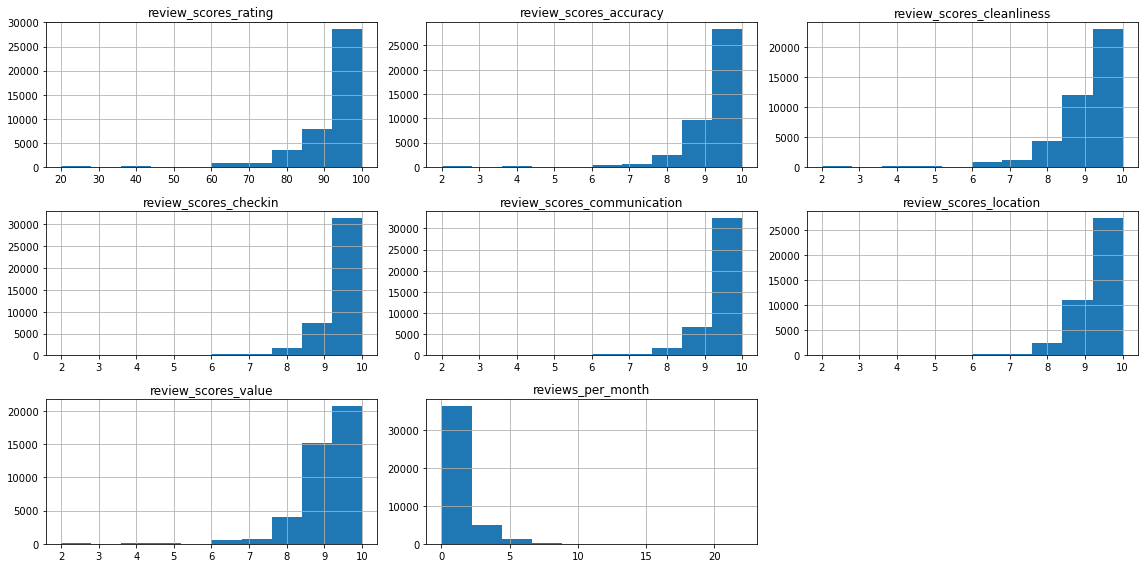

In [38]:
# Checking the distributions of the review columns and reviews_per_month
to_plot = list(df_known.columns[df_known.columns.str.startswith('review_scores') == True])
to_plot.append('reviews_per_month')
fig = plt.figure(figsize=(16,8))
for i, var_name in enumerate(to_plot):
    ax = fig.add_subplot(3,3,i+1)
    df_known[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

All score features have a similar distribution with most of the ratings being 10 of 10 which seems to be the standard. Hence values of 8 or 7 can already be considered as unsatisfactory. This low variation lowers the information content of these features. For `reviews_per_month` low values are the most frequent ones. All review features are imputed using the median.

In [39]:
# Imputing missing values in the review columns as well as reviews_per_month with the respective median
for col in to_plot:
    df_known[col].fillna(df_known[col].median(), inplace=True)
    df_unknown[col].fillna(df_known[col].median(), inplace=True)

# For reviews_per_month
df_known.reviews_per_month.fillna(df_known.reviews_per_month.median(), inplace=True)
df_unknown.reviews_per_month.fillna(df_known.reviews_per_month.median(), inplace=True)

In [40]:
# Get frequencies of cancellation_policy
print(df_known.cancellation_policy.value_counts())

def replace(df):
    ''' Replacing categories of cancellation_policy. '''
    df.cancellation_policy.replace({
        'luxury_super_strict_95': 'super_strict_60',
        'strict': 'strict_14_with_grace_period',
        'luxury_moderate': 'moderate'
        }, inplace=True)
    
# Apply replace
replace(df_known)
replace(df_unknown)

strict_14_with_grace_period    24102
flexible                       17094
moderate                       13643
super_strict_60                  230
super_strict_30                  211
strict                             2
luxury_moderate                    1
luxury_super_strict_95             1
Name: cancellation_policy, dtype: int64


Regarding the `cancellation_policy` feature, low frequent policies are assigned to the best matching policy with higher frequency.

### 2.5 Airbnb Prices

Finally let's take a look at the target feature `price`.

In [41]:
print(f"Nightly prices range from £{min(df_known.price)} to £{max(df_known.price)}.")
print(f"There are {len(df_known.price.unique())} unique prices in df_known.")

Nightly prices range from £10.0 to £500.0.
There are 476 unique prices in df_known.


It seems like the prices got bounded prior to this analysis. There is a low amount of variation in the values `price` takes on.

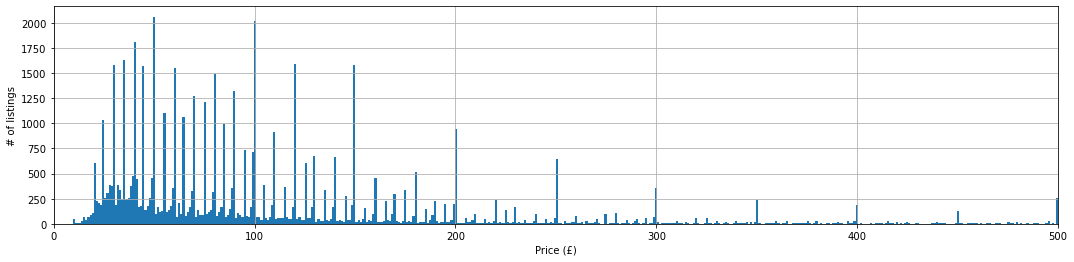

In [42]:
# Distribution of prices from £0 to £1000
plt.figure(figsize=(18,4))
df_known.price.hist(bins=476, range=(0,500))
plt.margins(x=0)
plt.xlabel("Price (£)")
plt.ylabel("# of listings")
plt.show()

The distribution of `price` confirms at least the existance of a upper bound. It is worth noticing that certain price values occur more often than others. This finishes the exploratory data analysis and the non-text data pre-processing.

## 3. Text Data  Pre-processing <a class='anchor' id='third-bullet'></a>

Having pre-processes the non-text features, this section thematizes the pre-processing of the text feature columns. Note that this is mostly done on the dataset `df_merged` that created earlier by merging `df_known` and `df_unknown`. At first all  missing values in text features in all three datasets are imputed with empty strings and converted to string as a whole.

In [43]:
# Convert text columns to sting and impute missings with empty strings
preprocess = ['name', 'summary', 'description', 'space', 'neighborhood_overview', 'transit', 'house_rules']
for col in preprocess:
    df_merged.loc[df_merged[col].isna(), col] = ''
    df_merged[col]=df_merged[col].apply(str)
    df_known.loc[df_known[col].isna(), col] = ''
    df_known[col]=df_known[col].apply(str)
    df_unknown.loc[df_unknown[col].isna(), col] = ''
    df_unknown[col]=df_unknown[col].apply(str)

### 3.1 Subset Detection

As found at the beginning of the exploratory  data analysis `summary` and `description` seem to be duplicates or share subsets. In fact the `summary` entries are often pasted at the beginning of the  `description` entries. Let's list all entries to whom this applies in `subset`, those with empty strings in one of the columns to `nan_subset` and the rest to `rest_subset`.

In [44]:
df = pd.DataFrame()
subset = []

# Determine rows in which 'summary' is a subset of 'description'
for i in range(0,len(df_merged)):
    try:
        subset.append(df_merged['summary'][i]==df_merged['description'][i][0:len(df_merged['summary'][i])])
    except TypeError :
        subset.append(False)

# Write to data frame and redefine subset and non_subset as respective indices      
df['subset'] = subset
subset = df_merged['summary'][df['subset'] == True].index
non_subset = df_merged['summary'][df['subset'] == False].index

# Define indeces of missings in eigther 'summary' or 'description'
nan_subset = []
for i in non_subset:
    if isinstance(df_merged['summary'][i], float) or isinstance(df_merged['description'][i], float):
        nan_subset.append(i)

# Infer the remaining indices
rest_subset = [ind for ind in non_subset if ind not in nan_subset]

In [45]:
## Check one rest_subset entry of 'summary' and 'description'
print(df_merged['summary'][rest_subset[0]])
print()
print(df_merged['description'][rest_subset[0]][0:len(df_merged['summary'][rest_subset[0]])])

Welcome to this modern studio room with clean, fresh decor, ensuite bathroom, fully equipped kitchen, Wi-fi & TV and a small rear patio.  With its own entrance, it's completely self contained with private use of all the facilities.  It's situated on a quiet street near a park with shops, restaurants and all amenities close by. Edmonton is in transport Zone 4 about an hour from central London. The apartment is about 10-15 minutes from the train station and the area is served by several buses.

Welcome to this modern studio room with clean, fresh decor, ensuite bathroom, fully equipped kitchen, Wi-fi & TV and a small rear patio.  With its own entrance, it's completely self contained with private use of all the facilities.  It's situated on a quiet street near a park with shops, restaurants and all amenities close by. Edmonton is in transport Zone 4 about an hour from central London. The apartment is about (Phone number hidden by Airbnb) minutes from the train station and the area i


In [46]:
# Check entry of 'description' with new logic
df_merged['description'][rest_subset[0]][0:(len(df_merged['summary'][rest_subset[0]])+len('(Phone number hidden by Airbnb)')-len('xx-xx'))]

"Welcome to this modern studio room with clean, fresh decor, ensuite bathroom, fully equipped kitchen, Wi-fi & TV and a small rear patio.  With its own entrance, it's completely self contained with private use of all the facilities.  It's situated on a quiet street near a park with shops, restaurants and all amenities close by. Edmonton is in transport Zone 4 about an hour from central London. The apartment is about (Phone number hidden by Airbnb) minutes from the train station and the area is served by several buses."

Checking a entry of the `rest_subset` shows that specification of time windows of the shape xx-xx in `summary` get recognized as phone number. Hence they are hidden and substituted with '(Phone number hidden by Airbnb)' in `description` by some Airbnb algorithm. Accounting for this in the processing logic yields the desired subset result from `description`.

In [47]:
# Check 'description' of description_subset
description_subset = []
for i in rest_subset:
    if '(Phone number hidden by Airbnb)' not in df_merged['description'][i]:
        description_subset.append(i)
df_merged['description'][description_subset]

3031                                 Dinner take .Sofa tv.
7711                 Fully fluent in French and in English
7780     We love this neighborhood! You can find everyt...
7919     Besides your own room, with tv and private bat...
10817    Fresh towels, tea, coffee and linen will be pr...
13559    Hi there ! We offer a great one bed flat in th...
14760    We are offering a private room  with space for...
20375    You will be given your own fob and key for any...
22102    Guests will have access to the entire property...
27459    beautiful studio apartment in the heart of pri...
27656    I loved that house as soon as I saw it.  It's ...
31772    Our flat is located in a new and cool building...
36442                                        Primrose Hill
37267    All rooms accessible. Guests will be the only ...
37462                                              Parejas
40281    Willesden Green is a residencial area. Ideal f...
42906    Whilst away, I will be available over text, (U.

All entries of rest_subset that do not have '(Phone number hidden by Airbnb)' in `description` are assumed to be proper. However a non english entry (index 66369) is visible here. Hence languages have to be checked in the subsequent section. First the changes to `description` are applied by removing the subset `summary`.

In [48]:
# Remove subset characters and redefine 'description' from subset and rest_subset
new_entrys = []
for i in range(0,len(df_merged)):
    if i in subset:
        new_entrys.append(df_merged['description'][i][len(df_merged['summary'][i]):])
    elif i in [ind for ind in rest_subset if ind not in description_subset]:
        new_entrys.append(df_merged['description'][i][(len(df_merged['summary'][i])+len('(Phone number hidden by Airbnb)')-len('xx-xx')):])   
    else:
        new_entrys.append(df_merged['description'][i])
df_merged['description'] = new_entrys

In [49]:
# Check rest_subset 'description' entry
print(df_merged['summary'][rest_subset[0]])
print()
print(df_merged['description'][rest_subset[0]])   

Welcome to this modern studio room with clean, fresh decor, ensuite bathroom, fully equipped kitchen, Wi-fi & TV and a small rear patio.  With its own entrance, it's completely self contained with private use of all the facilities.  It's situated on a quiet street near a park with shops, restaurants and all amenities close by. Edmonton is in transport Zone 4 about an hour from central London. The apartment is about 10-15 minutes from the train station and the area is served by several buses.

 This space consists of a double room with an en suite bathroom and storage closet.  Additionally, you will have sole use of a separate, fully equipped kitchen and there is a small courtyard at the back. Laundry facilities, bedding, towels and all cooking/eating utensils are provided. ACCESS VIA THE BROWN WOODEN DOOR TO THE SIDE OF THE BUILDING. The studio has its own entrance to the side of the house. So you'll have private use of the all the facilities, including the rear


Now `summary` is not occurring in the `description` entries but the text sequences do likely have a high dependency to eachother.

### 3.2 Text Data Cleaning & Correction

For the cleaning of the text columns a pre-selection of relevant features is made since the cleaning as well as the feature extraction via natural language processing (NLP) techniques are time expensive. Hence in order to prevent running into infeasable calculation and due to the substancial amounts of missing values  `space`, `neighborhood_overview`, `transit` and `house_rules` are not cleaned and hence won't serve for feature extraction in section 5. Hence cleaning is only done for `name`, `summary` and `description` and for conveniece in one step using `df_merged`.

####  Load Pre-processed Text Data

NOTE: The cleaned data is [provided](https://www.dropbox.com/sh/5of2lc58qmkk8bk/AADzQndCICjT1lAQo6Mp3RHFa?dl=0) and can be loaded from the notebook location using the following code.

In [ ]:
# Load the cleaned text data and merge it to df_known and df_unknown
clean = ['name_clean', 'summary_clean', 'description_clean']
for col in clean:
    with open(col + '_correct.pkl','rb') as path_name:
        df_merged[str(col)] = pickle.load(path_name)
    df_known[str(col)] = list(df_merged[str(col)][0:len(df_known)])
    df_unknown[str(col)] = list(df_merged[str(col)][len(df_known):len(df_merged)])

####  Generate Pre-processed Text Data

As found earlier the entries of the text features are possibly non english. Let's check this first.

In [50]:
def language_detection(text):
    ''' Detect the language of a string. '''
    try:
        return detect(text)
    except:
        return None

In [51]:
# Apply language_detection to 'name' and 'summary'
start = time.time()
df_merged['language_name'] = df_merged['name'].apply(language_detection)
df_merged['language_summary'] = df_merged['summary'].apply(language_detection)
print('Detected languages in {} mins.'.format(round((time.time() - start) / 60, 2)))

Detected languages in 22.99 mins.


In [52]:
# Check for share of occuring languages in 'name' and 'summary'
df = pd.DataFrame()
df['language_name_in_%'] = df_merged.language_name.value_counts(normalize=True)*100
df['language_sum_in_%'] = df_merged.language_summary.value_counts(normalize=True)*100
df.head(10)

,language_name_in_%,language_sum_in_%
en,85.388778,99.164958
nl,2.944359,0.052190
af,2.331490,0.054675
de,2.324432,0.060888
fr,1.890366,0.198820
da,0.744618,0.023610
it,0.677567,0.082013
ro,0.662275,0.017397
es,0.459946,0.098167
ca,0.419951,0.006213


Apparently several entries of `name` got labled as non english but this is not true for the `summary` entries. This discriptancy could be due to the short strings in `name` that can couse a higher amount of misclassifications. Hence this is assumed to be a minor problem and is not investigated further.

Therefore the functions for the text feature cleaning are defined for a first cleaning step.

In [53]:
# Lemmatize with POS Tag
def get_wordnet_pos(word):
    '''Map POS tag to first character for lemmatization'''
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {'J': wordnet.ADJ,
                'N': wordnet.NOUN,
                'V': wordnet.VERB,
                'R': wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [54]:
def clean(df):
    ''' NLP pre-processing chain including removal of html tags, non-alphabetic/numerical characters, and stopwords 
        as well as splitting numbers from letters, remove of newlines and transforming numbers to words.
        Words are tokenized and subject to lemmatization using their POS tags, which are determind using WordNet. '''
    names = []
    lemmatizer = WordNetLemmatizer()
    p = inflect.engine()
    print('*' * 40)
    print('Cleaning {} data entries of '.format(df.shape[0]) + col + ':')
    counter = 0
    for text in df:
        # remove non-alphabetic/numerical characters
        text = re.sub('[^_0-9a-zA-Z]',' ', text)
        # remove html content
        text = BeautifulSoup(text).get_text()
        # split numbers from letters
        text = ' '.join(str(e) for e in re.split('(\d+)',text))
        # remove newlines
        text = text.replace('\n', ' ')
        text = text.replace('\xa0', ' ')
        text = re.sub(' +', ' ', text)
        # tokenize the sentences
        words = word_tokenize(text.lower()) 
        # filter stopwords
        words = [w for w in words if w not in stopwords.words('english')] 
        # numbers to words
        for i,w in enumerate(words):
            if w.isnumeric() == True:
                words[i] = p.number_to_words(w)
        # lemmatize each word to its lemma
        lemma_words =[lemmatizer.lemmatize(i, get_wordnet_pos(i)) for i in words] 

        names.append(lemma_words)
        if (counter > 0 and counter % 2500 == 0):
            print('Processed {} entries...'.format(counter))
        counter += 1
    print('DONE!')
    print('*' * 40)

    return(names) 

Note that compared to the lecture notebook NLP pre-processing workflow, numbers are kept, splitted from other characters and translated into words. Moreover newlines are removed.

In [55]:
# Apply clean to the selected text columns
to_clean = ['name', 'summary', 'description']
start = time.time()
for col in to_clean:
    df_merged[str(col) + '_clean'] = clean(df_merged[col])
end = time.time()
print('Cleaned all entries in {} mins.'.format(round((time.time() - start) / 60, 2)))

****************************************
Cleaning 85053 data entries of name:
Processed 2500 entries...
Processed 5000 entries...
Processed 7500 entries...
Processed 10000 entries...
Processed 12500 entries...
Processed 15000 entries...
Processed 17500 entries...
Processed 20000 entries...
Processed 22500 entries...
Processed 25000 entries...
Processed 27500 entries...
Processed 30000 entries...
Processed 32500 entries...
Processed 35000 entries...
Processed 37500 entries...
Processed 40000 entries...
Processed 42500 entries...
Processed 45000 entries...
Processed 47500 entries...
Processed 50000 entries...
Processed 52500 entries...
Processed 55000 entries...
Processed 57500 entries...
Processed 60000 entries...
Processed 62500 entries...
Processed 65000 entries...
Processed 67500 entries...
Processed 70000 entries...
Processed 72500 entries...
Processed 75000 entries...
Processed 77500 entries...
Processed 80000 entries...
Processed 82500 entries...
Processed 85000 entries...
DONE!
*

Cleaning the entries of the text features preselected words via the stopwords filter / lemmatization and gave a clear structure to the entries via tokenizing.

Based on this a second correction step is undertaken. It aims on correcting miswritten words and expanding contractions/abbreviations. This is done by importing pre-trained [100-dimensional wiki2vec](https://wikipedia2vec.github.io/wikipedia2vec/pretrained/) embeddings from the directory of the notebook to identify words as unusual if in corpus but not in wiki2vec. Those words are then corrected to words that are both in the corpus and wiki2vec. 

The embedding can be downloaded using: http://wikipedia2vec.s3.amazonaws.com/models/en/2018-04-20/enwiki_20180420_100d.txt.bz2

In [56]:
# Import wiki2vec embeddings
start = time.time()
wiki2vec = KeyedVectors.load_word2vec_format(os.path.join(path, 'enwiki_20180420_100d.txt.bz2'))
print('Loaded wiki2vec embeddings in {} mins'.format(round((time.time() - start) / 60, 2)))

Loaded wiki2vec embeddings in 9.55 mins


In [57]:
def odd_words(liste):
    ''' Filter words that are not part of wiki2vec. '''
    words = []
    for word in liste:
        try:
            wiki2vec[word]
        except KeyError:
            words.append(word)
    return words

def word_count(df):
    ''' Count words in corpus. '''
    word_counter = Counter()
    for r in df:
        for w in r:
            word_counter.update({w: 1})
    return word_counter
            
def correct(df):
    ''' Correction of miswritten words and expanding contractions/abbreviations. '''
    # Build vocab
    w2v_model = Word2Vec(min_count=1)  
    w2v_model.build_vocab(df) 
    # Apply odd_words and word_count
    words = odd_words(list(w2v_model.wv.key_to_index))
    counts = word_count(df)
    # Define dict and counter of corrections
    wordDict = enchant.Dict('en_GB')
    correct_count = 0
    # Infer correction that is most frequent in vocab
    for word in words:
        suggestion = []
        suggestions = wordDict.suggest(word)
        for i in range(0,len(suggestions)):
            if suggestions[i] in list(w2v_model.wv.key_to_index):
                suggestion.append(suggestions[i])
                s_count = []
                for s in suggestion:
                    s_count.append(counts[s])
                    sug = suggestion[s_count.index(max(s_count))]
                    for j in range(0,len(df_known)):
                        if word in df[j]:
                            df[j][df[j].index(word)] = sug
                            correct_count += 1
    print('Corrected {} words in '.format(correct_count) + col)

In [58]:
# Apply correct to the selected text columns
start = time.time()
to_correct = ('name_clean', 'summary_clean', 'description_clean')
for col in to_correct:
    correct(df_merged[col])
    # Write feature to notebook directory
    with open(col + '_correct.pkl','wb') as path_name:
         pickle.dump(df_merged[str(col)], path_name)
            
print('DONE!')
print('Correction took {} mins.'.format(round((time.time() - start) / 60, 2)))

Corrected 612 words in name_clean
Corrected 7180 words in summary_clean
Corrected 11808 words in description_clean
DONE!
Correction took 55.12 mins.


This second step finishes the text data cleaning and correction section. The text data are written to the location of the notebook. In the final step the cleaned and corrected features are added to `df_known` and `df_unknown` from `df_merged`.

In [59]:
# Merge the cleaned text data to df_known and df_unknown
clean = ['name_clean', 'summary_clean', 'description_clean']
for col in clean:
    df_known[str(col)] = list(df_merged[str(col)][0:len(df_known)])
    df_unknown[str(col)] = list(df_merged[str(col)][len(df_known):len(df_merged)])

## 4. Feature Engineering & Selection <a class='anchor' id='fourth-bullet'></a>

With all relevant features being sufficiently pre-processed, the feature engineering is conducted by using  non-text features and meta data from the text features. The subsequent feature selection is done with the help of a Lasso regression i.e. the $L1$ norm.

### 4.1 Meta Data, Transformations & Dummy Encoding

The meta information of the text features, feature transformations  as well as dummy encoding is used for feature engineering.

In [51]:
# Infer legth of text columns as features
new_col = ['length_name','length_summary','length_description','length_space',
           'length_neighborhood_overview','length_transit','length_house_rules']
text_col = ['name','summary','description','space','neighborhood_overview','transit','house_rules']
for i in range(0,len(new_col)):
    df_known[new_col[i]] = df_known[text_col[i]].str.len()
    df_unknown[new_col[i]] = df_unknown[text_col[i]].str.len()

The length of each text feature is generated in order to indicate the amount of information provided by the host via text.

In [52]:
def mis_count(data, new_cols):
    ''' Count missings in text columns per row. '''
    counter = [0] * len(data)
    for i in new_cols:
        for j in list(data.loc[data[i] != 0].index):
            counter[j] = counter[j] + 1
    return(counter)

# Apply mis_count
df_known['text_count'] = mis_count(df_known, new_col)
df_unknown['text_count'] = mis_count(df_unknown, new_col)

Further the number of empty text entries in text features per row is generated to refine the measurement of the amount of information.

In [53]:
def amenities_length(data):
    ''' Count number of amenities per entry (list). '''
    liste = []
    for i in range(0,len(data)):
        liste.append(len(data.amenities[i]))
    return(liste)

# Apply amenities_length and create new feature
df_known['length_amenities'] = amenities_length(df_known)
df_unknown['length_amenities'] = amenities_length(df_unknown)

The number of amenities in the `amenities` list entries is counted to indicate how much equipment the Airbnb unit provides.

In [54]:
def trans_cdnts(new_col, cdnts):
    ''' Transform the non-linear coordiante features into linear features. '''
    df_known[new_col] = np.abs(df_known[cdnts] - np.mean(df_known[cdnts]))
    df_unknown[new_col] = np.abs(df_unknown[cdnts] - np.mean(df_unknown[cdnts]))
    return(df_known[new_col], df_unknown[new_col])

# Apply trans_cdnts and create new features
df_known['abs_longitude'], df_unknown['abs_longitude'] = trans_cdnts('abs_longitude', 'longitude')
df_known['abs_latitude'], df_unknown['abs_latitude'] = trans_cdnts('abs_latitude', 'latitude')

The non linear features `longitude` and `latitude` are transformed to linear ones that neglect east/west, north/south effects and hence only captures center to suburb location effects on `price` for the respective axis.  

In [55]:
# One-hot encoding of all amenities list entries
amenities_dummies = pd.get_dummies(df_known['amenities'].apply(pd.Series).stack()).groupby(level=0).sum()
df_known = pd.merge(df_known, amenities_dummies, how='left', left_index=True, right_index=True)
amenities_dummies = pd.get_dummies(df_unknown['amenities'].apply(pd.Series).stack()).groupby(level=0).sum()
df_unknown = pd.merge(df_unknown, amenities_dummies, how='left', left_index=True, right_index=True)

In [56]:
# Get list of categorical features that are suited for one-hot encoding via data type
to_dummy = [col for col in df_known.columns[df_known.dtypes == 'object'] 
            if col not in (text_col+clean+['amenities','listing_id'])]

# One-hot encode categorical features
for i in to_dummy:
    df_known = pd.merge(df_known, pd.get_dummies(df_known[i]), how='left', left_index=True, right_index=True)
    df_unknown = pd.merge(df_unknown, pd.get_dummies(df_unknown[i]), how='left', left_index=True, right_index=True)

The entries in the lists of `amenities` as well as all relevant categorical features get one-hot encoded into dummy features for each unique category.

### 4.2 Non-Text Feature Selection

Upon all non-text feature the ones that are usable and relevant for the final model are identified and selected in the following. 

In [57]:
# Safe listing_ids for submission
listing_ids = df_unknown.listing_id

# Define list of columns to be dropped along with the categorical features and the original text columns
to_drop = ['host_id','amenities','listing_id']

# Drop unnecessary features 
df_known = df_known.drop(text_col + to_dummy + to_drop, axis=1).copy()
df_unknown = df_unknown.drop(text_col + to_dummy + to_drop, axis=1).copy()

All unprocessed text columns are dropped since they are neighter needed for further operations nor usable in the final NN model. This also holds true for the categorical features as well as `host_id` and `listing_id`. The latter is safed for the submissions.

Every feature that is present in `df_known` but not in `df_unknown` and vice versa is dropped since the final Neural Network model would otherwise not be applicable.

In [58]:
# Define and drop columns that are not in both datasets df_known and df_unknown
liste = [i for i in df_known.columns if i not in df_unknown.columns]
liste.remove('price')
df_known = df_known.drop(liste, axis=1).copy()
df_unknown = df_unknown.drop([i for i in df_unknown.columns if i not in df_known.columns], axis=1).copy()
print('After dropping not needed and unusable features the datasets have {} columns in common.'.format(len(df_known.columns)-4))

After dropping not needed and unusable features the datasets have 728 columns in common.


In [59]:
# Define columns to keep for further feature extraction
keep_known = df_known[['price','name_clean', 'summary_clean', 'description_clean']]
keep_unknown = df_unknown[['name_clean', 'summary_clean', 'description_clean']]

# Apply Robust Scaler to df_known and df_unknown 
scaler = RobustScaler()
X_lasso = pd.DataFrame(scaler.fit_transform(df_known.drop(['price'] + clean, axis=1).copy()),
                       columns=list(df_known.drop(['price'] + clean, axis=1).copy().columns))
df_unknown = pd.DataFrame(scaler.transform(df_unknown.drop(clean, axis=1).copy()),
                          columns=list(df_unknown.drop(clean, axis=1).copy().columns))

A robust scaler is used to - appart from the scaling - additionally mitigate the effect of outliers in the features of `df_known` and `df_unknown`. Feature selection is conducted via the $L1$ norm using a cross-validated lasso model that is applied to the scaled features of `df_known` with variying penalties. A test-train-split is neglected because the interest lies only on the variable selection via shrinked coefficients.

In [69]:
seed(1234)
cores = multiprocessing.cpu_count()
# Define GridSearch (Lasso with 5-fold-cross-validation and RMSE as evaluation score)
gs = GridSearchCV(estimator=Lasso(tol=0.01), param_grid={'alpha': np.arange(0.003,0.005,0.00025)},
                  scoring='neg_root_mean_squared_error', cv=5, verbose=0, n_jobs=cores-1)
# Fit GridSearch to scaled df_known
gs.fit(X_lasso, df_known.price)
# Get best CV score
print('Best CV neg-RMSE: %0.4f' % gs.best_score_)
# Get best parameter
print('Optimal meta-parameter: {}'.format(gs.best_params_))

Best CV neg-RMSE: -51.7036
Optimal meta-parameter: {'alpha': 0.004000000000000001}


In [60]:
# Fit model with the lr that yields the minimun RMSE and get null coefficients
seed(1234)
reg = Lasso(alpha=0.004, tol=0.01)
reg.fit(X_lasso,df_known.price)
print('At this alpha (penalty) value {} coefficients of 728 are set to 0.'.format(len(reg.coef_[reg.coef_ == 0])))

At this alpha (penalty) value 230 coefficients of 728 are set to 0.


A remarkable share of the feature coefficients in df_known were set to 0. Those get dropped from `df_known` and `df_unknown` and the target and the text columns needed for feature extraction are merged again.

In [61]:
# Drop null coefficient features
df_known = X_lasso.drop(list(X_lasso.columns[reg.coef_ == 0]), axis=1).copy()
df_unknown = df_unknown.drop(list(X_lasso.columns[reg.coef_ == 0]), axis=1).copy()

In [62]:
# Merge the 'to keep' columns with transformed features
df_known = pd.merge(keep_known, df_known, how='left', left_index=True, right_index=True)
df_unknown = pd.merge(keep_unknown, df_unknown, how='left', left_index=True, right_index=True)

## 5. Natural Language Processing & Transfer Learning  <a class='anchor' id='fifth-bullet'></a>

At this point all non-text features that appear in the final model are both generated and selected. Hence the focus is now on the extraction of further features from the pre-processed text columns `name_clean`, `summary_clean` and `description_clean`. This is done via three different NLP techniques namely a Latent Semantic Analysis (LSA), a Sentence-BERT model and RNN models. In this approach the NLP methods outputs - often originally designed for other use-cases - are used as features for the `price` prediction that resembles the downstream task. Here transfer learning refers to importing pre-trained models or labeled data that were output of some related prior task. Note that the text columns are merged to one input for each method due to limited computational time and resources. Still this is reasonable since `summary_clean` and `description_clean` seem to depend on each other as shown earlier in section 3.1. Hence the data inputs are the same for each method but - due to the unique processing of the text and the information within each method - extraction of information differs. Hence it is expected that inferring features with each additional method provides features with a sufficient amount of unique explanatory power towards the target `price`.

### 5.1 Latent Semantic Analysis

First the LSA is conducted. It is based on a distributional hypothesis that words with similar meaning occur in similar pieces of text. To asses that, words are counted per document giving a sparse matrix of size $rows \times n_{words}$. The resulting term-frequencies (tf) are weighted with the inverse document-frequency (idf) with according to the [sklearn logic](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html). The matrix dimensionality is then reduced using truncated singular value decomposition ([SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD)).

To make the TfidfVectorizer applicable the text data needs to be detokenized. After this operation is conducted, a train-test-split is applied.

In [63]:
detok_known = []
detok_unknown = []

def detokenize_text(df, liste):
    ''' Detokenize text in order to make TfidfVectorizer applicable. '''
    for i in range(0,len(df)):
        liste.append(TreebankWordDetokenizer().detokenize(df.name_clean[i] + df.summary_clean[i] + df.description_clean[i]))

# Apply detokenize_text
detokenize_text(df_known, detok_known)
detokenize_text(df_unknown, detok_unknown)

In [64]:
# Train-test-split for feature selection
X_train_nlp,X_test_nlp,y_train_nlp,y_test_nlp = train_test_split(detok_known, df_known.price, test_size=0.2, random_state=1234)

Due to computational burdens and dimishing returns from adding further low frequency words, $n_{words}$ is caped and only the 10000 most frequent words are considered by the TfidfVectorizer. It is trained on `detok_known` - that refers to the relevant text columns of `df_known` - in order to capture the whole vocabular available. Note that `df_unknown` is afterwards only transformed with these fitted values but is not fitted on. The same holds true for the test and train set created by the split.

In [65]:
# Define Bigram model and fit it to df_known
cv = TfidfVectorizer(ngram_range=(1,2), max_features=10000, min_df=0., max_df=1., sublinear_tf=True)
cv_matrix = cv.fit_transform(detok_known).toarray()

In [66]:
# Get vocab and create the data frames for df_known and df_unknown with the respective columns
vocab = cv.get_feature_names()
ngram_known = pd.DataFrame(cv_matrix, columns=vocab)
ngram_unknown = pd.DataFrame(cv.transform(detok_unknown).toarray(), columns=vocab)

# Create the data frames for train and test
ngram_train = pd.DataFrame(cv.transform(X_train_nlp).toarray(), columns=vocab)
ngram_test = pd.DataFrame(cv.transform(X_test_nlp).toarray(), columns=vocab)

# Show matrix for df_known
ngram_known

,abbey,abbey road,abbey wood,able,able access,able enjoy,able escape,able help,able use,abroad,...,zero seven,zero six,zero three,zero two,zone,zone four,zone one,zone three,zone two,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55279,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55281,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55282,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The high dimensions causes a very sparse matrix with most entries being 0. To reduce dimensionality the SVD is well suited here because it - in contrast to the Principal Component Analysis (PCA) - does not require a prior normalization. This process is called latent semantic indexing where - following the distributional hypothesis - the words are combined to context representations via the principal components. Based on this components the predictive performance of a linear model is used as heuristic decision support in order to select the number of components.

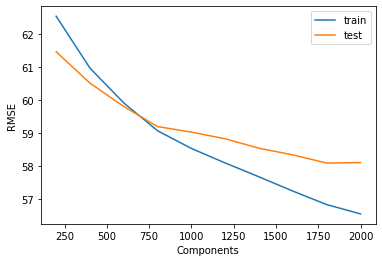

In [77]:
components = list(np.arange(200,2200,200))
train_results = []
test_results = []

for comp in components:
    # Define model (LR) at the component level
    svd = TruncatedSVD(n_components=comp, n_iter=3, random_state=1234).fit(ngram_train)
    svd_train = svd.transform(ngram_train)
    svd_test = svd.transform(ngram_test)
    reg = LinearRegression()
    reg.fit(svd_train, y_train_nlp) # Fit model
    rmse = np.sqrt(mean_squared_error(y_train_nlp, reg.predict(svd_train)))
    train_results.append(rmse)
    rmse = np.sqrt(mean_squared_error(y_test_nlp, reg.predict(svd_test)))
    test_results.append(rmse)
    
# Plot AUC values for train and test set
plt.plot(components, train_results, label='train')
plt.plot(components, test_results, label='test')
plt.ylabel('RMSE')
plt.xlabel('Components')
plt.legend()
plt.show()

It becomes visible that the predictive performance is maximized around 1800 components. However to avoid inflating the datasets with that components and lower the dimensionality of the final datasets, 800 components are selected for the downstream task. This is done following a elbow argument.

In [67]:
# Get transformed embeddings according to the number of principle components in feature selection
svd = TruncatedSVD(n_components=800, n_iter=5, random_state=1234).fit(ngram_known)
ngram_known_svd = pd.DataFrame(svd.transform(ngram_known))
ngram_unknown_svd = pd.DataFrame(svd.transform(ngram_unknown))

# Show matrix for df_known
ngram_known_svd

,0,1,2,3,4,5,6,7,8,9,...,790,791,792,793,794,795,796,797,798,799
0,0.159498,0.023450,0.109469,0.031132,-0.027434,-0.028695,0.002652,-0.071087,-0.002496,0.005611,...,-0.018986,-0.010771,0.005983,-0.008411,-0.003738,-0.000124,-0.003654,-0.010226,0.019767,0.001446
1,0.195961,0.051235,0.043626,0.007016,0.023519,-0.013997,-0.040000,-0.072970,-0.100278,0.011672,...,0.000005,-0.006834,-0.010740,0.020836,0.000492,-0.012971,-0.002312,0.011209,0.026767,0.013342
2,0.062440,-0.004752,-0.028490,0.022086,0.001314,-0.019739,-0.042252,0.020539,0.033647,-0.016590,...,0.007283,-0.024735,0.002005,0.042596,-0.014682,0.017930,0.019937,0.007640,0.029362,0.019477
3,0.242497,0.037398,0.057897,-0.030894,-0.006105,-0.012370,0.012818,0.045001,-0.050574,0.038546,...,0.004300,0.004557,-0.005860,-0.000262,-0.009107,0.013518,0.029916,-0.017573,0.005871,0.001291
4,0.243072,0.075785,0.000711,0.022885,0.099849,-0.102738,0.024937,-0.043527,-0.050692,-0.012632,...,0.004910,0.013120,-0.032043,0.003290,-0.010968,-0.002732,-0.010282,-0.011217,0.011796,-0.011982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55279,0.188328,-0.017626,-0.026422,0.011807,-0.043146,0.022587,0.032644,0.028786,0.047628,-0.029381,...,-0.034109,0.013565,-0.009224,-0.011548,0.016702,0.008345,-0.002487,-0.018773,0.009307,-0.000443
55280,0.143260,0.100627,0.089710,-0.006014,0.022165,-0.038052,0.028904,0.044964,-0.008983,-0.065376,...,-0.004057,-0.000799,-0.011068,-0.015107,-0.002003,0.011287,-0.010118,0.007281,0.010504,-0.005657
55281,0.247974,0.095353,0.030618,0.010558,-0.003190,-0.093997,-0.014045,0.025422,0.057962,-0.014335,...,0.015392,0.003334,-0.007447,-0.013702,0.006944,0.030639,-0.018105,-0.008770,-0.009057,-0.006741
55282,0.257567,0.112342,-0.051249,0.043760,-0.070266,0.018764,0.046558,0.034312,0.002739,-0.013268,...,0.007202,0.007663,0.009054,-0.004417,0.001896,0.026230,0.000098,0.000211,0.018708,-0.022469


Note that the resulting matrix is no longer sparse which follows the fact of having context representations here. The components are merged to `df_known` and `df_unknown` resulting in `df_known_nlp` and `df_unknown_nlp`.

In [68]:
# Merge the new features to df_known and df_unknown and create df_known_nlp and df_unknown_nlp
df_known_nlp = pd.merge(df_known, ngram_known_svd, how='left', left_index=True, right_index=True)
df_unknown_nlp = pd.merge(df_unknown, ngram_unknown_svd, how='left', left_index=True, right_index=True)

### 5.2 Fine-Tuned Sentence-BERT
As further NLP technique the [Sentence Bidirectional Encoder Representations from Transformers](https://www.sbert.net/) (SBERT)  according to [Reimers (2019)](https://arxiv.org/pdf/1908.10084.pdf) are used. Even though it was designed mainly for semantic textual similarity tasks, SBERT outperforms other state-of-the-art sentence embeddings methods on the SentEval transfer learning tasks (Reimers,2019,p.6f). Hence the idea is to import a pre-trained SBERT model and to refine its sentence embeddings with information towards `price` by tuning the model with the text and target data of this task. Herefore SBERT uses a [siamese network architecture](https://www.sbert.net/docs/training/overview.html) to learn similarities. This is done by encoding two sentences independently with a BERT model on the word level, applying mean pooling to get two sentence representations and calculating their cosine-similarity that is compared to a gold label via the mean squared error. Having identified to sentences $i,j$ to compare from the dataset entries, a non-negativ gold label is inferred from the target `price` via 

$$ \frac {\min\big(price_i, price_j\big)} {\max\big(price_i, price_j\big)} ~~~~~ \text{with} ~~~~~ i \neq j . $$

#### Load Sentence Embeddings for the Downstream Task

NOTE: The final embeddings are [provided](https://www.dropbox.com/sh/5of2lc58qmkk8bk/AADzQndCICjT1lAQo6Mp3RHFa?dl=0) and can be loaded from the directory of the notebook using the following code.

In [ ]:
# Load data frame from notebook location
emb_known = pd.read_pickle(path + '\\emb_known.pkl')
emb_unknown = pd.read_pickle(path + '\\emb_unknown.pkl')

# Merge transformed embeddings to df_known_nlp and df_unknown_nlp
df_known_nlp = pd.merge(df_known_nlp, emb_known, how='left', left_index=True, right_index=True)
df_unknown_nlp = pd.merge(df_unknown_nlp, emb_unknown, how='left', left_index=True, right_index=True)

#### Generate Sentence Embeddings for the Downstream Task

The text columns of the datasets are combined to `text_known` and `text_unknown`, a train-test-split is applied to `text_known` without shuffling and a fast (since training is done on the CPU) but still resonably good [general purpose SBERT](https://www.sbert.net/docs/pretrained_models.html) model is loaded.

In [69]:
# Merge cleaned text features
text_known = df_known_nlp.name_clean + df_known_nlp.summary_clean + df_known_nlp.description_clean
text_unknown = df_unknown_nlp.name_clean+df_unknown_nlp.summary_clean+df_unknown_nlp.description_clean

# Train-test-split for model training and feature selection
X_train_nlp,X_test_nlp,y_train_nlp,y_test_nlp = train_test_split(text_known, df_known.price, test_size=0.2, shuffle=False)

# Load a fast pre-trained SBERT model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2', device='cpu')

To get examples from pairs of sentences and gold labels for training and validation `train_examples` and `eval_examples` is defined. Here every index of non empty text entries is written to `non_empty` and generates examples with the next and the previous entry in the `non_empty` list. Following the EDA the data seems to be unordered hence this can be done to make the price and text entries appear equally often. On top of that a random assignment is conducted in `eval_examples` to identify further training examples. 

In [70]:
def train_examples(df_train, label_train):
    ''' Prepares examples from the train set for fine tuning. Each non-empty entry is combined
        both with the index neighbors in the dataset and one other entry that is selected randomly. '''
    seed(1234)
    examples=[]
    non_empty = list(df_train.index[df_train.str.len() != 0])
    
    for i in non_empty:
        if non_empty.index(i) < len(non_empty)-1:
            examples.append(InputExample(texts=[TreebankWordDetokenizer().detokenize(df_train[i]), 
                            TreebankWordDetokenizer().detokenize(df_train[non_empty[non_empty.index(i)+1]])],
                            label=float(min(label_train[i],label_train[i+1])/max(label_train[i],label_train[i+1]))))      
        j = random.sample(non_empty, 1)[0]
        examples.append(InputExample(texts=[TreebankWordDetokenizer().detokenize(df_train[i]), 
                        TreebankWordDetokenizer().detokenize(df_train[j])],
                        label=float(min(label_train[i],label_train[j])/max(label_train[i],label_train[j]))))
    return examples

In [71]:
def eval_examples(df_train, df_test, label_test):
    ''' Prepares examples from the test set for validation. Each non-empty
        entry is combined with the index neighbors in the dataset.'''
    val_example_1=[]
    val_example_2=[]
    score=[]
    non_empty = list(df_test.index[df_test.str.len() != 0])
    
    for i in non_empty:
        if non_empty.index(i) < len(non_empty)-1:
            val_example_1.append(TreebankWordDetokenizer().detokenize(df_test[i]))
            val_example_2.append(TreebankWordDetokenizer().detokenize(df_test[i+1]))
            score.append(float(min(label_test[i],label_test[i+1])/max(label_test[i],label_test[i+1])))
    return (val_example_1, val_example_2, score)

The text sequences used for the SBERT fine-tuning are trimmed via the 99% quantile of all text lengths in the dataset the model is frained on since long sequences disproportionately slow the training down. The unnormalized distribution of text sequence lengths is visualized with `plot_len_text`.

In [72]:
def plot_len_text(t_known, t_unknown):
    ''' Visulize the text lengths of the inputs. '''
    train_length = t_known.apply(lambda x: len(str(x).split()))
    test_length = t_unknown.apply(lambda x: len(str(x).split()))
    plt.subplots(1, 2, figsize=(16,8))
    plt.subplot(1, 2, 1)
    plt.title('Unnormalized Distribution in Train Data')
    plt.xlabel('Text length')
    train_length.plot.hist(bins=100);
    plt.subplot(1, 2, 2)
    plt.title('Unnormalized Distribution in Test Data')
    plt.xlabel('Text length')
    test_length.plot.hist(bins=100);
    plt.show()

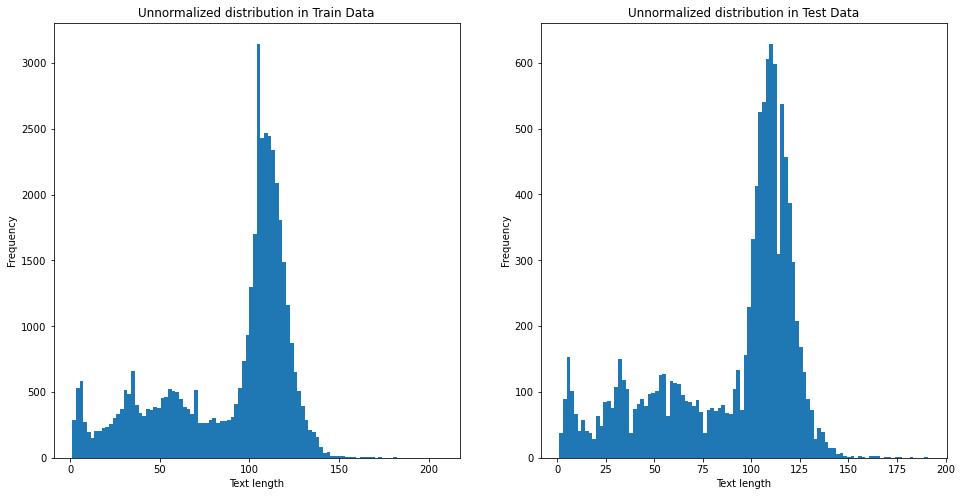

The trimmed input sequence has 135 words.


In [73]:
# Apply plot_len_text
plot_len_text(X_train_nlp, X_test_nlp)

# Apply plot_len_text
print('The trimmed input sequence has {} words.'.format(round(np.quantile([len(row) for row in X_train_nlp], .99))))

As trying several SBERT configurations proved to be costly the default settings were chosen mostly. This includes the optimizer `AdamW` featuring weight decay which also can be considered a go to optimizer in general. The `learning rate` was not changed, the number of `epochs` were set to 2 and only the `batch size` was tweaked to 32 via a trial-and-error approach.   

In [74]:
def train_SBERT(df_train, label_train, check_val, squantile, batch, lr, epoch):
    ''' Fine tunes the pre-trained SBERT model with the train set examples 
        while evaluation the validation examples. '''
    # Set seed
    seed(1234)
    tf.random.set_seed(1234)

    # Train examples
    examples = train_examples(df_train, label_train)

    # Train dataset, dataloader and train loss
    train_dataloader = DataLoader(examples, shuffle=True, batch_size=batch)
    train_loss = losses_trans.CosineSimilarityLoss(model)
    
    if check_val == True:
        print('NOTE: The validation results are written to the location of this notebook.')
        # Validation set
        val_example_1, val_example_2, score = eval_examples(df_train, X_test_nlp, y_test_nlp)
        evaluator = evaluation.EmbeddingSimilarityEvaluator(val_example_1, val_example_2, score)

        # Model tune
        model.max_seq_length = round(np.quantile([len(article) for article in df_train],squantile))
        model.fit(train_objectives=[(train_dataloader, train_loss)], optimizer_class = transformers.optimization.AdamW, 
                  optimizer_params={'lr': lr}, epochs=epoch, scheduler='warmuplinear', warmup_steps=500,
                  evaluator=evaluator, evaluation_steps=750, output_path=path, save_best_model=True)
    else:
        print('NOTE: The model is trained without validation.')
        # Model tune
        model.max_seq_length = round(np.quantile([len(article) for article in df_train],squantile))
        model.fit(train_objectives=[(train_dataloader, train_loss)], optimizer_class = transformers.optimization.AdamW, 
                  optimizer_params={'lr': lr}, epochs=epoch, scheduler='warmuplinear', warmup_steps=500)

In [75]:
# Apply train_SBERT with specified parameters
start = time.time()
train_SBERT(df_train=X_train_nlp, label_train=y_train_nlp, check_val=True, squantile=0.99, batch=32, lr=1e-05, epoch=2)
print('Fine-tuned SBERT in {} mins.'.format(round((time.time() - start) / 60, 2)))

NOTE: The validation results are written to the location of this notebook.


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2764 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2764 [00:00<?, ?it/s]

Fine-tuned SBERT in 613.93 mins


After this lengthy [fine-tuning](https://www.dropbox.com/sh/5of2lc58qmkk8bk/AADzQndCICjT1lAQo6Mp3RHFa?dl=0) the embeddings for the `X_train_nlp` and `X_test_nlp` are generated.

In [76]:
def SBERT_embeddings(df):
    ''' Encode sentence embeddings from a text dataset. '''
    emb = []
    for i in df.index:
        emb.append(model.encode(TreebankWordDetokenizer().detokenize(df[i])))
    emb = pd.DataFrame(list(map(np.ravel, emb)))
    return emb

In [77]:
# Get train and test embeddings
start = time.time() 
emb_train = SBERT_embeddings(X_train_nlp)
emb_test = SBERT_embeddings(X_test_nlp)
print('Generated train-test-split embeddings in {} mins'.format(round((time.time() - start) / 60, 2)))

# Show matrix for X_train_nlp
emb_train

Generated train-test-split embeddings in 24.57 mins


,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,0.189542,0.392975,0.302139,0.218513,-0.425760,0.027421,0.140458,-0.324446,0.229403,0.078695,...,-0.205246,-0.230925,0.084034,0.062469,0.112039,0.423573,0.111190,0.035582,-0.720320,0.351114
1,0.119399,-0.042429,-0.010332,0.288744,0.184945,0.115508,-0.061338,-0.063945,0.307620,0.407092,...,0.533489,-0.163256,-0.029592,-0.394045,0.069414,0.564027,-0.802099,0.269396,-0.502291,-0.099281
2,0.365716,0.088738,0.267167,0.390709,0.150001,0.067298,-0.470908,-0.334243,0.885332,0.789138,...,-0.236426,-0.184523,-0.392375,0.367119,0.473331,0.110570,-0.483798,0.700526,-0.642666,0.638225
3,0.121512,-0.047635,0.278845,0.241184,0.292837,0.248273,-0.212196,0.137666,0.313116,-0.026654,...,-0.099417,-0.262282,-0.020034,0.474873,0.020947,0.321221,-0.062608,-0.212191,-0.397943,0.218615
4,0.025619,-0.103982,0.208132,0.118253,-0.094092,0.239723,-0.065192,-0.148167,0.104161,0.104174,...,0.028859,-0.296767,-0.258262,-0.077715,0.209897,0.362213,-0.419707,0.127951,-0.478318,0.168880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44222,0.530532,-0.125428,0.093384,0.240216,0.293408,0.128390,0.371852,0.105309,0.028543,0.401294,...,0.207598,0.067537,-0.445330,0.204478,-0.619232,0.347581,-0.511850,0.209651,-0.248858,0.382064
44223,0.189005,0.236335,0.038817,0.197560,0.101726,0.318470,0.290009,0.001175,0.233470,-0.103045,...,0.055201,-0.166744,0.085137,0.217222,-0.335350,0.582121,-0.672144,0.192083,-0.260439,0.216185
44224,0.176956,-0.293005,-0.058808,0.134380,0.180420,0.112965,0.201180,0.062239,-0.149403,0.145873,...,-0.031010,-0.021076,0.108447,0.234328,-0.646962,0.376159,-0.459907,0.146992,-0.645388,0.213801
44225,0.353657,-0.218997,0.125641,0.165881,-0.091599,0.413311,-0.021333,0.095831,0.352625,0.039859,...,0.083537,-0.195184,-0.383868,0.255606,-0.258900,0.464035,0.109063,-0.064268,-0.600925,0.304587


Since the embedding matrices are not sparse a normalization and Principal Component Analysis (PCA) is used for possible reductions of dimensionality.

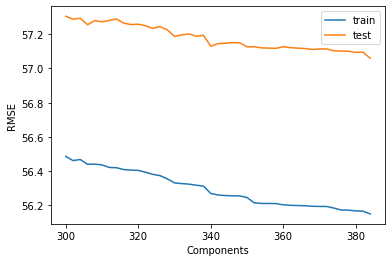

In [79]:
liste = list(np.arange(300,386,2))
train_results = []
test_results = []
reg = LinearRegression()

for comp in liste:
    # Define model Principal Component Regression (PCR) by number of components
    pca = PCA(n_components=comp).fit(emb_train)
    pca_train = pca.transform(emb_train)
    pca_test = pca.transform(emb_test)
    reg.fit(pca_train, y_train_nlp) # Fit model
    rmse = np.sqrt(mean_squared_error(y_train_nlp, reg.predict(pca_train)))
    train_results.append(rmse)
    rmse = np.sqrt(mean_squared_error(y_test_nlp, reg.predict(pca_test)))
    test_results.append(rmse)
    
# Plot AUC values for train and test set
plt.plot(liste, train_results, label='train')
plt.plot(liste, test_results, label='test')
plt.ylabel('RMSE')
plt.xlabel('Components')
plt.legend()
plt.show()

In [82]:
reg.fit(emb_train,y_train_nlp)
print('Best PCR Test RMSE:', min(test_results))
print('RMSE of LR with raw embeddings:', np.sqrt(mean_squared_error(y_test_nlp, reg.predict(emb_test))))

Best PCR Test RMSE: 57.0598087853739
RMSE of LR with raw embeddings: 57.0598087854382


However a dimensionality reduction does not increase predictive performance for the downstream task as shown by the linear regressions as model for heuristic decision support. Hence the final embeddings will be used directly.

Let's fine-tune the SBERT model further with the unseen labeled data that was prior used for validation to get the final SBERT model.

In [83]:
start = time.time()
train_SBERT(df_train=X_test_nlp, label_train=y_test_nlp, check_val=False, squantile=0.99, batch=32, lr=1e-05, epoch=2)
print('Fine-tuned SBERT in {} mins.'.format(round((time.time() - start) / 60, 2)))

NOTE: The model is trained without validation.


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/691 [00:00<?, ?it/s]

Iteration:   0%|          | 0/691 [00:00<?, ?it/s]

Fine-tuned SBERT in 135.96 mins


Now the final embeddings are generated from `text_known` and `text_unknown` and merged to `df_known_nlp` and `df_unknown_nlp`. They are also stored in the directory of the notebook.

In [84]:
# Get embeddings for df_known and df_unknown
start = time.time() 
emb_known = SBERT_embeddings(text_known)
emb_unknown = SBERT_embeddings(text_unknown)
print('Generated final embeddings in {} mins'.format(round((time.time() - start) / 60, 2)))

Generated final embeddings in 38.38 mins


In [85]:
# Merge transformed embeddings to df_known_nlp and df_unknown_nlp
df_known_nlp = pd.merge(df_known_nlp, emb_known, how='left', left_index=True, right_index=True)
df_unknown_nlp = pd.merge(df_unknown_nlp, emb_unknown, how='left', left_index=True, right_index=True)

In [86]:
# Store data frame to notebook location
emb_known.to_pickle(path + '\\emb_known.pkl')
emb_unknown.to_pickle(path + '\\emb_unknown.pkl')

### 5.3 Recurrent Neural Networks

The last NLP technique used to extract features from the text data are the standard designs of Gated Recurrent Neural Networks (RNN). Those are the Gated Recurrent Unit (GRU) and Long Short-Term Memory (LSTM). To make use of transfer learning the respective model weights are initilized with the pre-trained 100-dimensional wiki2vec embeddings that were already part of  the text data correction in section 3.2. The RNN models are then used to predict the target `price` directly from the merged text data columns `text_known` and `text_unknown`. This predictions are including as feature in the downstream task which can be considered as a special form of model stacking.

#### Load RNN Predictions for Stacking 

NOTE: The RNN predictions are [provided](https://www.dropbox.com/sh/5of2lc58qmkk8bk/AADzQndCICjT1lAQo6Mp3RHFa?dl=0) and can be loaded from the directory of the notebook using the following code.

In [ ]:
# Load data frame from notebook location
pred_RNN_known = pd.read_pickle(path + '\\pred_RNN_known.pkl')
pred_RNN_unknown = pd.read_pickle(path + '\\pred_RNN_unknown.pkl')

# Merge predictions to df_known_nlp and df_unknown_nlp
df_known_nlp = pd.merge(df_known_nlp, pred_RNN_known, how='left', left_index=True, right_index=True)
df_unknown_nlp = pd.merge(df_unknown_nlp, pred_RNN_unknown, how='left', left_index=True, right_index=True)

#### Generate RNN Predictions for Stacking 

Let's first load the wiki2vec embeddings from the notebook directory in case the where not loaded earlier.

Again the embedding can be downloaded using: http://wikipedia2vec.s3.amazonaws.com/models/en/2018-04-20/enwiki_20180420_100d.txt.bz2

In [87]:
# If not loaded already import wiki2vec embeddings
if 'wiki2vec' not in locals():
    start = time.time() 
    wiki2vec = KeyedVectors.load_word2vec_format(os.path.join(path, 'enwiki_20180420_100d.txt.bz2'))
    print('Loaded wiki2vec embeddings in {} mins.'.format(round((time.time() - start) / 60, 2)))
else:
    print('Wiki2vec embeddings already in environment.')

Loaded wiki2vec embeddings in 10.31 mins.


To infer a embedding matrix for the corpus of the merged text data the function `get_embedding_matrix` is defined and based on this all relevant inputs for the RNN models - weights for inizialization, training data, test data, number of words, sequence length - are generated by the function `get_inputs`. Here the word sequences are trimmed to the 99% quantile of the sequence lengths again. The functions are applied after merging the text data columns (Just in case they were not merged in section 5.2).

In [88]:
def get_embedding_matrix(tokenizer, pretrain, vocab_size):
    '''Helper function to construct an embedding matrix for 
       a given corpus based on some pre-trained embeddings.'''
    dim = 0
    if isinstance(pretrain, KeyedVectors) or isinstance(pretrain, Word2VecKeyedVectors):
        dim = pretrain.vector_size        
    elif isinstance(pretrain, dict):
        dim = next(iter(pretrain.values())).shape[0]  # get embedding of an arbitrary word
    else:
        raise Exception('{} is not supported'.format(type(pretrain)))
    
    # Initialize embedding matrix
    emb_mat = np.zeros((vocab_size, dim))

    # There will be some words in our corpus for which we lack a pre-trained embedding.
    # In this tutorial, we will simply use a vector of zeros for such words. We also keep
    # track of the words to do some debugging if needed
    oov_words = []
    # Below we use the tokenizer object that created our task vocabulary. This is crucial to ensure
    # that the position of a words in our embedding matrix corresponds to its index in our integer
    # encoded input data
    for word, i in tokenizer.word_index.items():  
        # try-catch together with a zero-initilaized embedding matrix achieves our rough fix for oov words
        try:
            emb_mat[i] = pretrain[word]
        except:
            oov_words.append(word)
    print('Created embedding matrix of shape {}'.format(emb_mat.shape))
    print('Encountered {} out-of-vocabulary words.'.format(len(oov_words)))
    return (emb_mat, oov_words)

In [89]:
def get_inputs(data_train, data_test, quant):
    ''' Transforms, counts and trims the text data for the usage in a RNN model.
        and applys get_embedding_matrix to yield pre-trained embeddings'''
    # Tokenizing and # of words in corpus
    tokenizer = Tokenizer(oov_token=1)
    tokenizer.fit_on_texts(data_train)
    NUM_WORDS = len(tokenizer.word_index) + 1

    # Encode the train data
    X_tr_int = tokenizer.texts_to_sequences(data_train)
    max_tr_length = max([len(article) for article in X_tr_int])

    # Encode the test data
    X_ts_int = tokenizer.texts_to_sequences(data_test)
    max_ts_length = max([len(article) for article in X_ts_int])
    
    # Padding and trimming of sequence
    tr_length = round(np.quantile([len(row) for row in data_train], quant))
    print('The trimmed input sequence has {} words.'.format(tr_length))
    X_tr_int = pad_sequences(X_tr_int, tr_length)
    X_ts_int = pad_sequences(X_ts_int, tr_length)
    
    # Apply get_embedding_matrix
    wiki_weights, _ = get_embedding_matrix(tokenizer, wiki2vec, NUM_WORDS)
    
    return (wiki_weights, X_tr_int, X_ts_int, NUM_WORDS, tr_length)

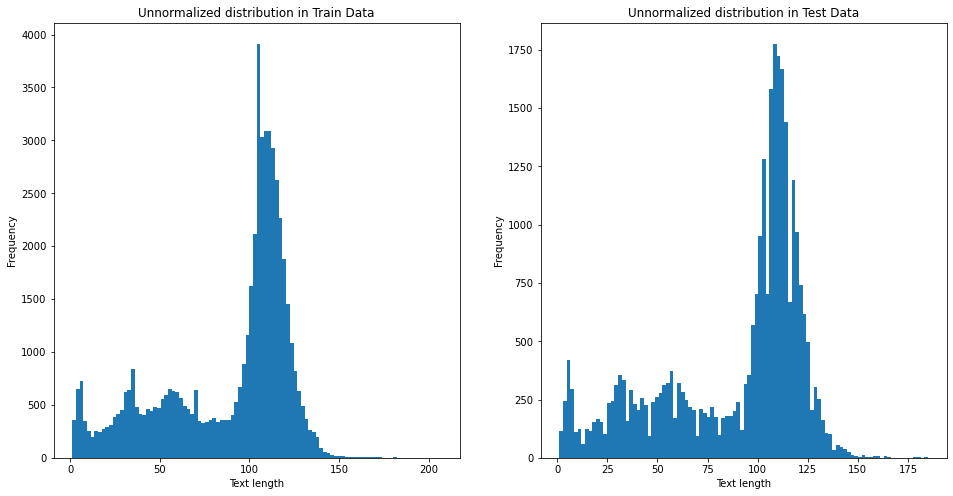

In [90]:
# Merge cleaned text columns to one text features
text_known = df_known_nlp.name_clean + df_known_nlp.summary_clean + df_known_nlp.description_clean
text_unknown = df_unknown_nlp.name_clean + df_unknown_nlp.summary_clean + df_unknown_nlp.description_clean

# Apply plot_len_text
plot_len_text(text_known, text_unknown)

In [91]:
# Apply get_embedding_matrix and get_inputs
word2vec_weights, data_known, data_unknown, NUM_WORDS, tr_length = get_inputs(text_known, text_unknown, 0.99)

The trimmed input sequence has 135 words.
Created embedding matrix of shape (28512, 100)
Encountered 4514 out-of-vocabulary words.


There are several words that are out-of-vocabulary and do not have a wiki2vec embedding. Hence - and to be able to adjust existing embeddings - the RNN model embeddings are `trainable`. The `output dimension` and the number of `hidden units` are set to 100 which is equal to the dimension of the `inizilized embeddings`. Note that the main challenge of providing RNN predictions in the downstream task is overfitting because models are trained on data referin to `df_known` and also predict the prices in `df_known`. Hence `price` data to predict is leaked during training. To mitigate this the validation `split` is increased to 35% validation data and the models are only considered up to the point where they start overfitting. This is indicated by a disproportional increase in the train loss compared to the validation loss. To possibly delay overfitting a 50% `dropout` layer is applied.

Further specifications of the RNNs including `learning rate` and `batchs` were set with a trail-and-error approach. Bidirectional and deep structures showed no improvement in this setting, a Relu activation function in the `output layer` showed to be supperior to a linear one and the `optimizer` RMSprop performes better than Adam. As `loss function` the mean squared error (MSE) is used since the prediction is a regression task with the target being of metric scale and the number of `epochs` are given subject to early stopping.

In [93]:
# Set seed 
seed(1234)
tf.random.set_seed(1234)

# Structure
input_layer = Input(shape=(tr_length, ))
embeddings = Embedding(NUM_WORDS, output_dim=100, embeddings_initializer=Constant(word2vec_weights),
                       input_length=tr_length, trainable=True)(input_layer)
GRU_ = GRU(100, activation='tanh', return_sequences=False)(embeddings)
Drop = Dropout(1/2)(GRU_)
output_layer = Dense(1, activation='relu')(Drop)

# Parameter
split = len(df_unknown)/(len(df_merged)) 
learning_rate = 5e-04
batchs = 32
epochs = 25

# Define, compile and fit the model
model = Model(inputs=[input_layer], outputs = output_layer)
model.compile(loss = losses.MeanSquaredError(), optimizer = optimizers.RMSprop(learning_rate=learning_rate)) 
print(model.summary())
callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=1, min_delta=0.01, restore_best_weights=True)]
story = model.fit([data_known], np.array(df_known.price), epochs=epochs, verbose=1, batch_size=batchs, 
                   validation_split=split, callbacks=callbacks, shuffle=True)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 135)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 135, 100)          2851200   
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               60600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 2,911,901
Trainable params: 2,911,901
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
1123/1123 [==============================] - 75s 66ms/step - loss: 11628.3135 - val_loss: 8410.2451

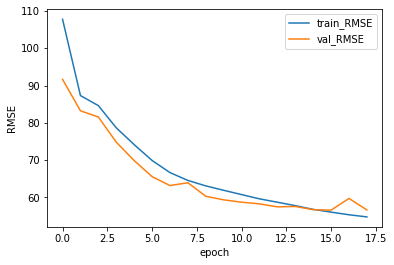

Best Val RMSE: 56.60297671197382


In [94]:
def show_history(story):
    ''' Visualize the model training history. '''
    plt.plot(np.sqrt(story.history['loss']))
    plt.plot(np.sqrt(story.history['val_loss']))
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train_RMSE', 'val_RMSE'], loc='best')
    plt.show()
    
#Apply show_history
show_history(story)
print('Best Val RMSE:', np.sqrt(min(story.history['val_loss'])))

Note that overfitting is graphically indicated by the point of the training root MSE (RMSE) crosses the validation RMSE for some epoch.

In [95]:
# Set seed 
seed(1234)
tf.random.set_seed(1234)

# Structure
input_layer = Input(shape=(tr_length, ))
embeddings = Embedding(NUM_WORDS, output_dim=100, embeddings_initializer=Constant(word2vec_weights),
                       input_length=tr_length, trainable=True)(input_layer)
LSTM_ = LSTM(100, activation='tanh', return_sequences=False)(embeddings)
Drop = Dropout(1/2)(LSTM_)
output_layer = Dense(1, activation='relu')(Drop)

# Parameter
split = len(df_unknown)/(len(df_merged)) 
learning_rate = 5e-04
batchs = 32
epochs = 30

# Define, compile and fit the model
model = Model(inputs=[input_layer], outputs = output_layer)
model.compile(loss = losses.MeanSquaredError(), optimizer = optimizers.RMSprop(learning_rate=learning_rate)) 
print(model.summary())
callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=1, min_delta=0.01, restore_best_weights=True)]
story = model.fit([data_known], np.array(df_known.price), epochs=epochs, verbose=1, batch_size=batchs, 
                   validation_split=split, callbacks=callbacks, shuffle=True)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 135)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 135, 100)          2851200   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 2,931,701
Trainable params: 2,931,701
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
1123/1123 [==============================] - 80s 70ms/step - loss: 11640.7559 - val_loss: 8414.5938

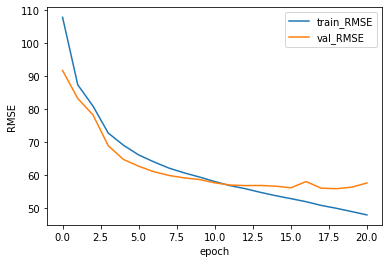

Best Val RMSE: 55.79065703242233


In [96]:
#Apply show_history
show_history(story)
print('Best Val RMSE:', np.sqrt(min(story.history['val_loss'])))

Both RNN models behave quite similar. However training GRU for 15 `epochs` seems to be slightly superior to training LSTM for 12 `epochs` when considering overfitting as main issue.

In [99]:
start = time.time()

# Set seed 
seed(1234)
tf.random.set_seed(1234)

# Structure
input_layer = Input(shape=(tr_length, ))
embeddings = Embedding(NUM_WORDS, output_dim=100, embeddings_initializer=Constant(word2vec_weights),
                       input_length=tr_length, trainable=True)(input_layer)
GRU_ = GRU(100, activation='tanh', return_sequences=False)(embeddings)
Drop = Dropout(1/2)(GRU_)
output_layer = Dense(1, activation='relu')(Drop)

# Parameter
split = len(df_unknown)/(len(df_merged)) 
learning_rate = 5e-04
batchs = 32
epochs = 15

# Define, compile and fit the model
model = Model(inputs=[input_layer], outputs = output_layer)
model.compile(loss = losses.MeanSquaredError(), optimizer = optimizers.RMSprop(learning_rate=learning_rate)) 

callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=0, min_delta=0.01, restore_best_weights=True)]
story = model.fit([data_known], np.array(df_known.price), epochs=epochs, verbose=0, batch_size=batchs, 
                   validation_split=split, callbacks=callbacks, shuffle=True)

print('Training the GRU model took {} mins.'.format(round((time.time() - start) / 60, 2)))
print('Best Val RMSE:', np.sqrt(min(story.history['val_loss'])))

Training the GRU model took 17.4 mins.
Best Val RMSE: 56.719724939967975


With the trained GRU model predictions for `price` are generated. Those are scaled using the robust scaler to have a common scale with the non-text features, merged to df_known_nlp and df_unknown_nlp and written to the notebook directory. This finishes the NLP and transfer learning part.

In [102]:
# Predict prices for df_known and df_unknown
preds_RNN_known = model.predict([data_known])
preds_RNN_unknown = model.predict([data_unknown])

In [103]:
# Merge robust scaled predictions to df_known_nlp and df_unknown_nlp (stacking model)
scaler = RobustScaler()
df_known_nlp = pd.merge(df_known_nlp, pd.DataFrame(scaler.fit_transform(preds_RNN_known)),
                        how='left', left_index=True, right_index=True)
df_unknown_nlp = pd.merge(df_unknown_nlp, pd.DataFrame(scaler.transform(preds_RNN_unknown)),
                          how='left', left_index=True, right_index=True)

In [104]:
# Store data frame to notebook location
pd.DataFrame(scaler.fit_transform(preds_RNN_known)).to_pickle(path + '\\pred_RNN_known.pkl')
pd.DataFrame(scaler.transform(preds_RNN_unknown)).to_pickle(path + '\\pred_RNN_unknown.pkl')

## 6. Feedforward Neural Network for Price Prediction <a class='anchor' id='sixth-bullet'></a>

In [193]:
print('{} features are available for modeling.'.format(len(df_known_nlp.columns)-4))

1683 features are available for modeling.


`df_known_nlp` and `df_unknown_nlp` now include all non-text features and extracted features from test data. Those are robust scaled metric features, metric features from embeddings and dummy features. They are now used for the prediction of price which is done with a feedforward neural network (NN) architecture. To evaluate the architecture a train-test-split is applied and the function `get_train_results` is defined to be able to judge the NN performance.

In [194]:
# Train-test-split for predictive performance test 
X_train,X_test,y_train,y_test = train_test_split(df_known_nlp.drop(['price']+clean, axis=1).copy(), 
                                                 df_known_nlp.price, test_size=0.2, random_state=1234)

In [195]:
def show_history(story):
    ''' Visualize the model training history. '''
    plt.plot(np.sqrt(story.history['loss']))
    plt.plot(np.sqrt(story.history['val_loss']))
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train_RMSE', 'val_RMSE'], loc='best')
    plt.show()

In [196]:
def get_train_results(story, X_test, y_test):
    ''' Get relevant training results. '''
    #Apply show_history
    show_history(story)
    print('Best Val RMSE:', np.sqrt(min(story.history['val_loss'])))

    # Get RMSE of the test set
    score = model.evaluate(X_test, y_test, verbose=0)
    print('Test RMSE:', np.sqrt(score))

#### Model Structures & Tuning

In general and for all structures the mean squared error (MSE) as `loss function` and a linear `activation function` in the output layer is used since the prediction is a regression task. The `activation function` of `hidden layers` is Relu in combination with the `inizializer` HeNormal. A 50% `dropout layer` is used after the first `hidden layer` to mitigate overfitting. The numbers of `epochs`  are always determined using early stopping and the `validation split` is set to 20% of the training data.

At first the go to `optimizer` Adam with the default `learning rate` is utilized and a one `hidden layer` structure is used with a dimension of 2048 being larger then the `input` dimension. The `batch size` is fixed at the reasonable initial level of 64.

In [198]:
start = time.time()

# Set seed
seed(1234)
tf.random.set_seed(1234)

# NN structure 
inputs = Input(shape=(X_train.shape[1],))
layer1 = Dense(2048, activation='relu', kernel_initializer=initializers.he_normal(seed=123))(inputs)
drop_layer1 = Dropout(1/2)(layer1)
predictions = Dense(1, activation='linear')(drop_layer1)

# Parameter
batch_size = 64
epochs = 50
split = 0.2 

# Define, compile and fit the model
model = Model(inputs=inputs, outputs=predictions)
model.summary()
model.compile(loss='mean_squared_error', optimizer=optimizers.Adam())
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1, min_delta=0.01, restore_best_weights=True)]
story = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=split, 
                  verbose=0, callbacks=callbacks, shuffle=True)
print('Training the NN model took {} mins.'.format(round((time.time() - start) / 60, 2)))

Model: "model_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        [(None, 1683)]            0         
_________________________________________________________________
dense_107 (Dense)            (None, 2048)              3448832   
_________________________________________________________________
dropout_43 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_108 (Dense)            (None, 1)                 2049      
Total params: 3,450,881
Trainable params: 3,450,881
Non-trainable params: 0
_________________________________________________________________
Restoring model weights from the end of the best epoch.
Epoch 00019: early stopping
Training the NN model took 2.67 mins.


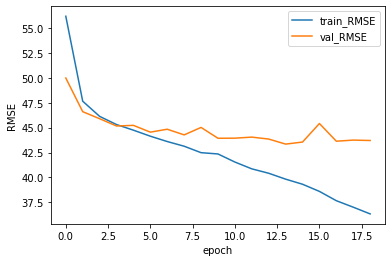

Best Val RMSE: 43.34466107324739
Test RMSE: 43.3849361593039


In [199]:
#Apply get_train_results
get_train_results(story, X_test, y_test)

This already worked quite good even though the validation path is a bit jumpy. Adding a further hidden layer to get a deep structure seems reasonable. Herewith the NN should be able to capture complex non linear relationships in the data - as seen in 2.2 with `latitude` and `longitude` - better. Hence a hidden layer of dimension 512 is added which is simply half of the features remaining after the dropout layer.

In [200]:
start = time.time()

# Set seed
seed(1234)
tf.random.set_seed(1234)

# NN structure 
inputs = Input(shape=(X_train.shape[1],))
layer1 = Dense(2048, activation='relu', kernel_initializer=initializers.he_normal(seed=123))(inputs)
drop_layer1 = Dropout(1/2)(layer1)
layer2 = Dense(512, activation='relu', kernel_initializer=initializers.he_normal(seed=123))(drop_layer1)
predictions = Dense(1, activation='linear')(layer2)

# Parameter
lr = 1e-03   # Tried to tweak
batch_size = 64
epochs = 50
split = 0.2 

# Define, compile and fit the model
model = Model(inputs=inputs, outputs=predictions)
model.summary()
model.compile(loss='mean_squared_error', optimizer=optimizers.Adam(learning_rate=lr))
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1, min_delta=0.01, restore_best_weights=True)]
story = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=split, 
                  verbose=0, callbacks=callbacks, shuffle=True)

print('Training the final NN model took {} mins.'.format(round((time.time() - start) / 60, 2)))

Model: "model_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        [(None, 1683)]            0         
_________________________________________________________________
dense_109 (Dense)            (None, 2048)              3448832   
_________________________________________________________________
dropout_44 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_110 (Dense)            (None, 512)               1049088   
_________________________________________________________________
dense_111 (Dense)            (None, 1)                 513       
Total params: 4,498,433
Trainable params: 4,498,433
Non-trainable params: 0
_________________________________________________________________
Restoring model weights from the end of the best epoch.
Epoch 00010: early stopping
Training the final NN model to

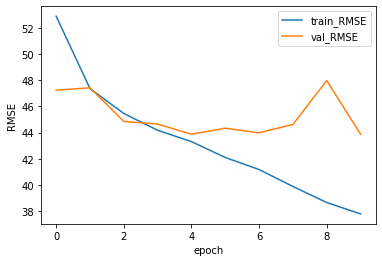

Best Val RMSE: 43.87783360908515
Test RMSE: 43.75578086807502


In [201]:
#Apply get_train_results
get_train_results(story, X_test, y_test)

The deep structure did not improve the result and made the validation path more instabile. Note that it was unsuccessfully tried to change the `leaning rate` to mitigate the problem but this either increased it or lowered the performance significantly. Hence a `optimizer` that may better suit this setting is considered. Since the data input formats vary - especially considering dummy features - and because of the complex deep structure with a large number of paramters, each dimension can have a different sensitivity towards the `learning rate` during backpropagation and gradient updates. To deal with this potential problem [Adagrad](https://golden.com/wiki/Adagrad) is exploited. It assigns a [parameter individual update](https://medium.com/konvergen/an-introduction-to-adagrad-f130ae871827) with a scaled `learning rate` according to the history of gradients resulting in smaller updates for frequently updated parameters. `learning rate`

In [202]:
start = time.time()

# Set seed
seed(1234)
tf.random.set_seed(1234)

# NN structure 
inputs = Input(shape=(X_train.shape[1],))
layer1 = Dense(2048, activation='relu', kernel_initializer=initializers.he_normal(seed=123))(inputs)
drop_layer1 = Dropout(1/2)(layer1)
layer2 = Dense(512, activation='relu', kernel_initializer=initializers.he_normal(seed=123))(drop_layer1)
predictions = Dense(1, activation='linear')(layer2)

# Parameter
lr = 6e-03
batch_size = 64
epochs = 50
split = 0.2 

# Define, compile and fit the model
model = Model(inputs=inputs, outputs=predictions)
model.summary()
model.compile(loss='mean_squared_error', optimizer=optimizers.Adagrad(learning_rate=lr))
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1, min_delta=0.01, restore_best_weights=True)]
story = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=split, 
                  verbose=1, callbacks=callbacks, shuffle=True)

print('Training the final NN model took {} mins.'.format(round((time.time() - start) / 60, 2)))

Model: "model_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        [(None, 1683)]            0         
_________________________________________________________________
dense_112 (Dense)            (None, 2048)              3448832   
_________________________________________________________________
dropout_45 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_113 (Dense)            (None, 512)               1049088   
_________________________________________________________________
dense_114 (Dense)            (None, 1)                 513       
Total params: 4,498,433
Trainable params: 4,498,433
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
553/553 [==============================] - 12s 21ms/step - loss: 2605.7839 - val_loss: 2191.0283
Epoch 

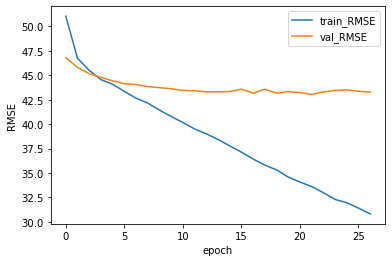

Best Val RMSE: 43.04609090710575
Test RMSE: 42.963239703499


In [203]:
#Apply get_train_results
get_train_results(story, X_test, y_test)

Changing the `optimizer` proved to be beneficial. Note that the `learning rate` as well as the `batch size` where tweaked several times and hence determined via trial-and-error. Further it was tried to go back to one `hidden layer` using Adagrad which did not yield a improvement. Hence having early stoppen after 22 `epochs` the above NN structure resembles the final NN model.

#### Final Model & Predictions

The NN model is now trained on the whole `df_known_nlp` dataset.

In [204]:
start = time.time()

# Set seed 
seed(1234)
tf.random.set_seed(1234)

# Building the model
inputs = Input(shape=(df_known_nlp.drop(['price']+clean, axis=1).copy().shape[1],))
layer1 = Dense(2048, activation='relu', kernel_initializer=initializers.he_normal(seed=123))(inputs)
drop_layer1 = Dropout(0.5)(layer1)
layer2 = Dense(512, activation='relu', kernel_initializer=initializers.he_normal(seed=123))(drop_layer1)
predictions = Dense(1, activation='linear')(layer2)

# Parameter
lr = 6e-03 
batch_size = 64
epochs = 22

# Compile and fit the model
model = Model(inputs=inputs, outputs=predictions)
model.compile(loss='mean_squared_error', optimizer=optimizers.Adagrad(learning_rate=lr))
model.fit(df_known_nlp.drop(['price']+clean, axis=1).copy(), df_known_nlp.price,
          batch_size=batch_size, epochs=epochs, verbose=0, shuffle=True)

print('Training the final NN model took {} mins.'.format(round((time.time() - start) / 60, 2)))

Training the final NN model took 5.73 mins.


With this model the predictions of `price` are generated. As seen in section 2.5 the prices do not have high variation with only 476 unique price options. However the model provides a greater range of price predictions and even up to several digits. Hence the predictions are transformed to the closest `price` provided by `df_known` to make it a realistic and comparable Airbnb price option. Considering the pricing use-case of the introduction this indicates the competitors price someone faces. It even showed to improve the Kaggle challenge result slightly.

In [205]:
# Generate price predictions for df_unknown
predictions = model.predict(df_unknown_nlp.drop(clean, axis=1).copy())

# Transform predictions - due to the low variation in the target price - to the prices that occured in df_known  
price_list = []
for i in predictions:
    price_list.append(min(list(df_known.price.unique()), key=lambda x:abs(x-i)))

Finally the predictions are prepared and written to the notebook directory. [Submitting them to Kaggle](https://www.dropbox.com/sh/5of2lc58qmkk8bk/AADzQndCICjT1lAQo6Mp3RHFa?dl=0) yields a public leaderboard RMSE score of 43.976  and a privat leaderboard RMSE score of 42.851. Note that this scores can vary slightly per notebook run since the random states do not work properly with SBERT.

In [206]:
# Prepare submission data frame 
listings = pd.DataFrame(listing_ids, columns=['listing_id'], index=df_unknown_nlp.index)
listings['price'] = price_list

# Write submisstion to csv and show head entries
listings.to_csv('submission.csv', index = False)
listings.head()

,listing_id,price
0,0FEMC4VA5U,115.0
1,PQ2BYEO0QR,169.0
2,3FP6WFHUBN,95.0
3,GG0V2KDG90,69.0
4,TZVVK4YSIO,130.0


## 7. Conclusion <a class='anchor' id='seventh-bullet'></a>

The aim of this assignment was to predict Airbnb prices using and combining both tabular data and text data. This was approached by extracting features from the text data using NLP techniques and merging them with the tabular data for the downstream task. After EDA and the pre-processing of the non-text data several promising features could be generate during feature engineering. The text data pre-processing entailed a language detection, data cleaning for the NLP methods with a special treatment of numbers as well as a correction of miswritten words, contractions and abbreviations. 

Based on this the NLP techniques were a LSA, a fine-tuned SBERT model and RNNs. The latter two made use of transfer learning. Regarding the individual prediction of the extracted features - measured heuristically with a LR model - the GRU showed the best performance, followed by the SBERT model and the LSA. However the potential for further improvements for the RNNs and the LSA can be considered small. Whereas the SBERT model shows high potential for further fine-tuning with further examples and by using all training data pars but here the computational burdens cannot be neglected. Hence training on the GPU would be a requirement then. Against that LSA is a fast and out-of-the-box NLP method. The RNNs require just some parameter and structure tuning but here it is obscure how to include them best into the downsteam task. A direct training in the downstream task using `concatenate` could be a alternative to the here used model stacking but would require a entirely new structure.  

Overall, given the heuristic individual NLP prediction RMSE results and the non-text data RMSE of 51.704 as measured heuristically with a LASSO model in section 4.2, every NLP method can be considered to have a positiv contibution in the downstream task. The predictions and the final RMSE result was produced with the optimizer Adagrad in a Deep NN structure.

The possible approaches that can be used for this assignment seem to be comprehensive and diverse therefore a lot was leaned during solving it.

## 8. Literature <a class='anchor' id='eight-bullet'></a>

- Reimers, N., & Gurevych, I. (2019). Sentence-bert: Sentence embeddings using siamese bert-networks. arXiv preprint arXiv:1908.10084.